<a href="https://colab.research.google.com/github/APFFM/project1/blob/main/Stocks_Comparison_KNN%2C_Random_Forest%2C_LSTM%2C_CNN%2C_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
import tensorflow
import keras
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras.optimizers import SGD
from keras.optimizers import Adam
import time
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.svm import SVR, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor

# Input Data from Yahoo Finance

In [4]:
ticker = 'AAPL'

In [5]:
# DF = pdr.get_data_yahoo('spy', start = '2000-01-01', end = '2017-10-1')
# DF.head()

DF = yf.download(ticker, start="2015-01-01", end="2023-11-15")
DF.head

[*********************100%%**********************]  1 of 1 completed


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   27.847500   27.860001   26.837500   27.332500   24.466452   
2015-01-05   27.072500   27.162500   26.352501   26.562500   23.777195   
2015-01-06   26.635000   26.857500   26.157499   26.565001   23.779428   
2015-01-07   26.799999   27.049999   26.674999   26.937500   24.112869   
2015-01-08   27.307501   28.037500   27.174999   27.972500   25.039339   
...                ...         ...         ...         ...         ...   
2023-11-08  182.350006  183.449997  181.589996  182.889999  182.649368   
2023-11-09  182.960007  184.119995  181.809998  182.410004  182.169998   
2023-11-10  183.970001  186.570007  183.529999  186.399994  186.399994   
2023-11-13  185.820007  186.029999  184.210007  184.800003  184.800003   
2023-11-14  187.699997  188.110001  186.300003  187.440002  187.440002   

       

In [6]:
#choose plotting style

#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
#plt.style.use('seaborn')

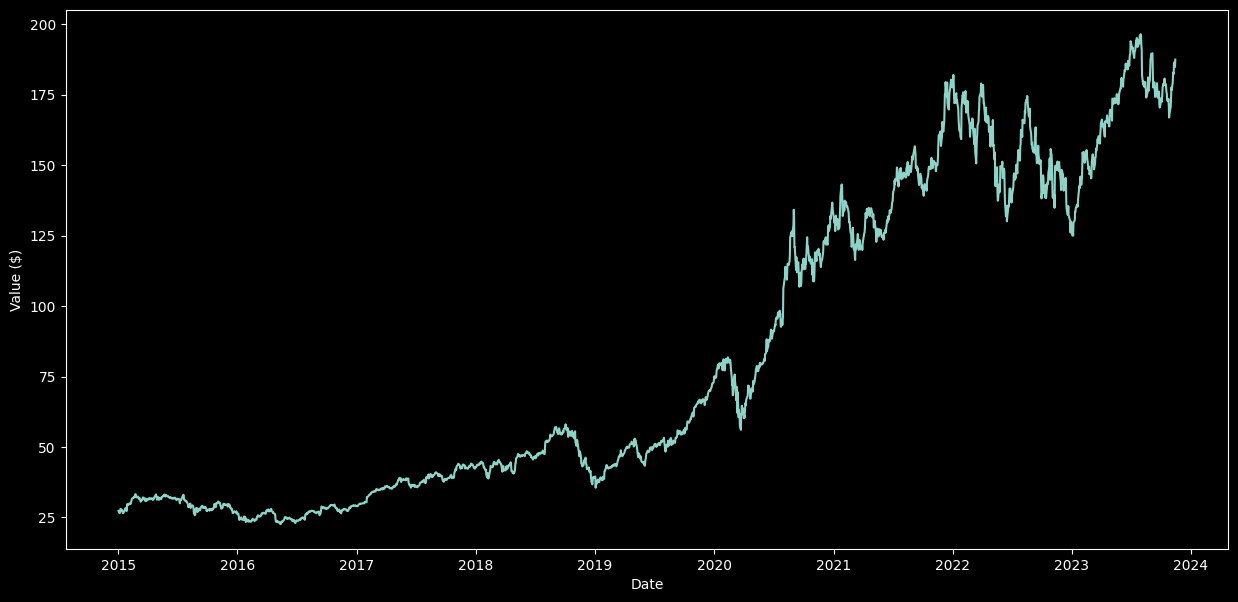

In [7]:
plt.figure(figsize=(15,7))
plt.plot(DF.Close)
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.rcParams.update({'font.size': 18})

# Define Functions

In [45]:
#creating datasets from the dataframe, make data stationary:
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff

def create_dataset_percentage_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]/dataset[i+window_size-1,0]-1
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

def create_dataset_difference_gap(dataset, window_size, look_forward, gap): #MinMaxScaler(feature_range=(0, 1))
    i = 0
    data_X, data_Y = [], []
    while i in range(len(dataset) - window_size - look_forward):
        a = dataset[i:(i + window_size), :]
        data_X.append(a)
        b = dataset[i + window_size + look_forward-1, 0]-dataset[i+window_size-1,0]
        data_Y.append(b)
        i += gap

    x = np.array(data_X)
    y = np.array(data_Y)
    y = y.reshape(-1,1)
    return (x,y)

#regression to classification:
def y_classifier(array, threshold):
    classes = []
    for i in range(len(array)):
        if array[i,0] > threshold:
            classes.append(1)
        elif array[i,0] < -1*threshold:
            classes.append(-1)
        else:
            classes.append(0)
    return np.asarray(classes)

#defining moving averages:
def EMA(df, EMA_days):
    sma = np.mean(df[0:EMA_days])
    EMA_list = [0] * (EMA_days - 1)
    EMA_list.append(sma)
    c = 2/(1+EMA_days)
    for i in range(EMA_days,len(df)):
        a = EMA_list[i-1]*(1-c)+ c*df[i]
        EMA_list.append(a)
    return(EMA_list)

def SMA(df, sma_days):
    sma_list = [0] * (sma_days - 1)
    for i in range(sma_days, len(df)+1):
        sma_list.append(np.mean(df[i-sma_days:i]))
    return(sma_list)

#defining some metrics
def rms(y, pred):
    temp = 0
    if len(y) != len(pred):
        return False
    else:
        for i in range(len(y)):
            temp += (y[i][0] - pred[i][0])**2
        return temp/len(y)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)+0.0000000001))

def mae(A, F):
    return 1/len(A) * np.sum(np.abs(F - A))

#autocorrelation benchmark:
def benchmark(y, look_forward):
    Y_hat = []
    Y_real = []
    for i in range(2*look_forward, len(y)):
        a = np.mean(y[i-2*look_forward:i-look_forward,0])
        Y_hat.append(a)
        Y_real.append(y[i,0])
    return (np.asarray(Y_real), np.asarray(Y_hat))


def pretty_print_conf_matrix(y_true, y_pred, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

def plot(y_train, prediction_train,y_test, prediction_test):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, prediction_train)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Train')


    plt.subplot(1, 2, 2)
    plt.scatter(y_test, prediction_test)
    plt.ylabel('predicted')
    plt.xlabel('actual')
    plt.title('ML-Test')
    plt.show()

    plt.figure(figsize=(15,8))
    plt.subplot(2, 1, 1)
    plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
    plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
    plt.grid()
    plt.legend()
    plt.title('Train')
    plt.subplots_adjust(hspace = 0.4)

    plt.subplot(2, 1, 2)
    plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
    plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
    plt.grid()
    plt.legend()
    plt.title('Test')

#this function changes 1D y array to an array with 3 features that is used for softmax
def y_softmax(array):
    lst = []
    for i in range(len(array)):
        if array[i] == 1:
            lst.append([1,0,0])
        elif array[i] == 0:
            lst.append([0,1,0])
        else:
            lst.append([0,0,1])
    return np.asarray(lst)


def softmaxifier(array):
    zeros = [0, 0, 0]
    pred = []
    for i in range(len(array)):
        j = np.argmax(array[i])
        temp = [0,0,0]
        temp[j] = 1
        pred.append(temp)
    return pred

#this function changes 3D y array with 3 features that was generated by softmax to an 1D array for confusion matrix
def desoftmaxer(array):
    lst = []
    for i in range(len(array)):
        if np.argmax(array[i]) == 0:
            lst.append(1)
        elif np.argmax(array[i]) == 1:
            lst.append(0)
        else:
            lst.append(-1)
    return (np.asarray(lst))
#fix random effect
def fix_rnd_Keras():
    seed_value= 0
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    #tf.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)
    from keras import backend as K
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

#split x and y to test and train that are devisible to batch_size
def test_train_split(x, y, batch_size, train_ratio):
    train_length = int(len(x)*train_ratio)
    for i in range(train_length, train_length+batch_size):
        remainder = i%batch_size
        if remainder == 0:
            train_length = i
            break
    x_train = x[:train_length,:]
    y_train = y[:train_length]

    for i in range(len(x)-batch_size, len(x)):
        remainder = i%batch_size
        if remainder == 0:
            train_length_test = i
            break
    x_test = x[train_length:train_length_test,:]
    y_test = y[train_length:train_length_test]
    return x_train, y_train, x_test, y_test

# Creating Features

In [9]:
df = DF.Close
df = df.dropna(axis=0, how='any')

#making moving averages
v_10 = SMA(DF.Volume, 10)
v_20 = SMA(DF.Volume, 20)
open_close = (DF.Close/DF.Open - 1).tolist()
high_low = (DF.High/DF.Low - 1).tolist()
EMA_8 = EMA(df,8)
SMA_10 = SMA(df,10)
SMA_20 = SMA(df,20)
SMA_50 = SMA(df,50)
SMA_100 = SMA(df,100)
pct_day = difference_pct_back(df, 1)
list_df = df.tolist()
vol_list = DF.Volume.tolist()
MAs = pd.DataFrame(list(zip(list_df, pct_day, vol_list, v_10, v_20,open_close,high_low, EMA_8, SMA_10,
                            SMA_20, SMA_50, SMA_100)),columns=['spot', 'pct_day', 'vol', 'v_10', 'v_20',
                            'open_close', 'high_low', 'EMA_8', 'SMA_10', 'SMA_20', 'SMA_50','SMA_100'])

#removing all rows with 0 in them
MAs = MAs[100:]
MAs = MAs.reset_index(drop=True)

#making differences as features
MAs['v10'] = MAs.vol/MAs.v_10 - 1
MAs['v20'] = MAs.vol/MAs.v_20 - 1
MAs['spot_EMA'] = MAs.spot/MAs.EMA_8 - 1
MAs['spot_20SMA'] = MAs.spot/MAs.SMA_20 - 1
MAs['spot_50SMA'] = MAs.spot/MAs.SMA_50 - 1
MAs['spot_100SMA'] = MAs.spot/MAs.SMA_100 - 1
MAs['10_100_SMA'] = MAs.SMA_10/MAs.SMA_100 - 1
MAs['20_50_SMA'] = MAs.SMA_20/MAs.SMA_50 - 1
MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)

<ipython-input-9-0b0d7e1f2e3d>:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  MAs = MAs.drop(['EMA_8', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'v_10', 'v_20'], 1)


# Initial Visualization

,spot,pct_day,vol,open_close,high_low,v10,v20,spot_EMA,spot_20SMA,spot_50SMA,spot_100SMA,10_100_SMA,20_50_SMA
0,32.945000,-0.001969,122933200,-0.000607,0.006484,-0.313947,-0.376899,0.007912,0.025485,0.033486,0.064791,0.054780,0.007802
1,32.570000,-0.011383,203538000,-0.007239,0.011932,0.121659,0.066591,-0.002771,0.011793,0.021432,0.050631,0.053808,0.009527
2,32.634998,0.001996,128451200,0.001996,0.010304,-0.282490,-0.307729,-0.000608,0.013187,0.022983,0.050670,0.053173,0.009669
3,32.490002,-0.004443,134670400,0.000770,0.010362,-0.217658,-0.260404,-0.003931,0.008192,0.017790,0.044136,0.051109,0.009520
4,32.529999,0.001231,123934000,-0.004133,0.008006,-0.256444,-0.305415,-0.002105,0.007745,0.018579,0.043892,0.049612,0.010751


<Figure size 640x480 with 0 Axes>

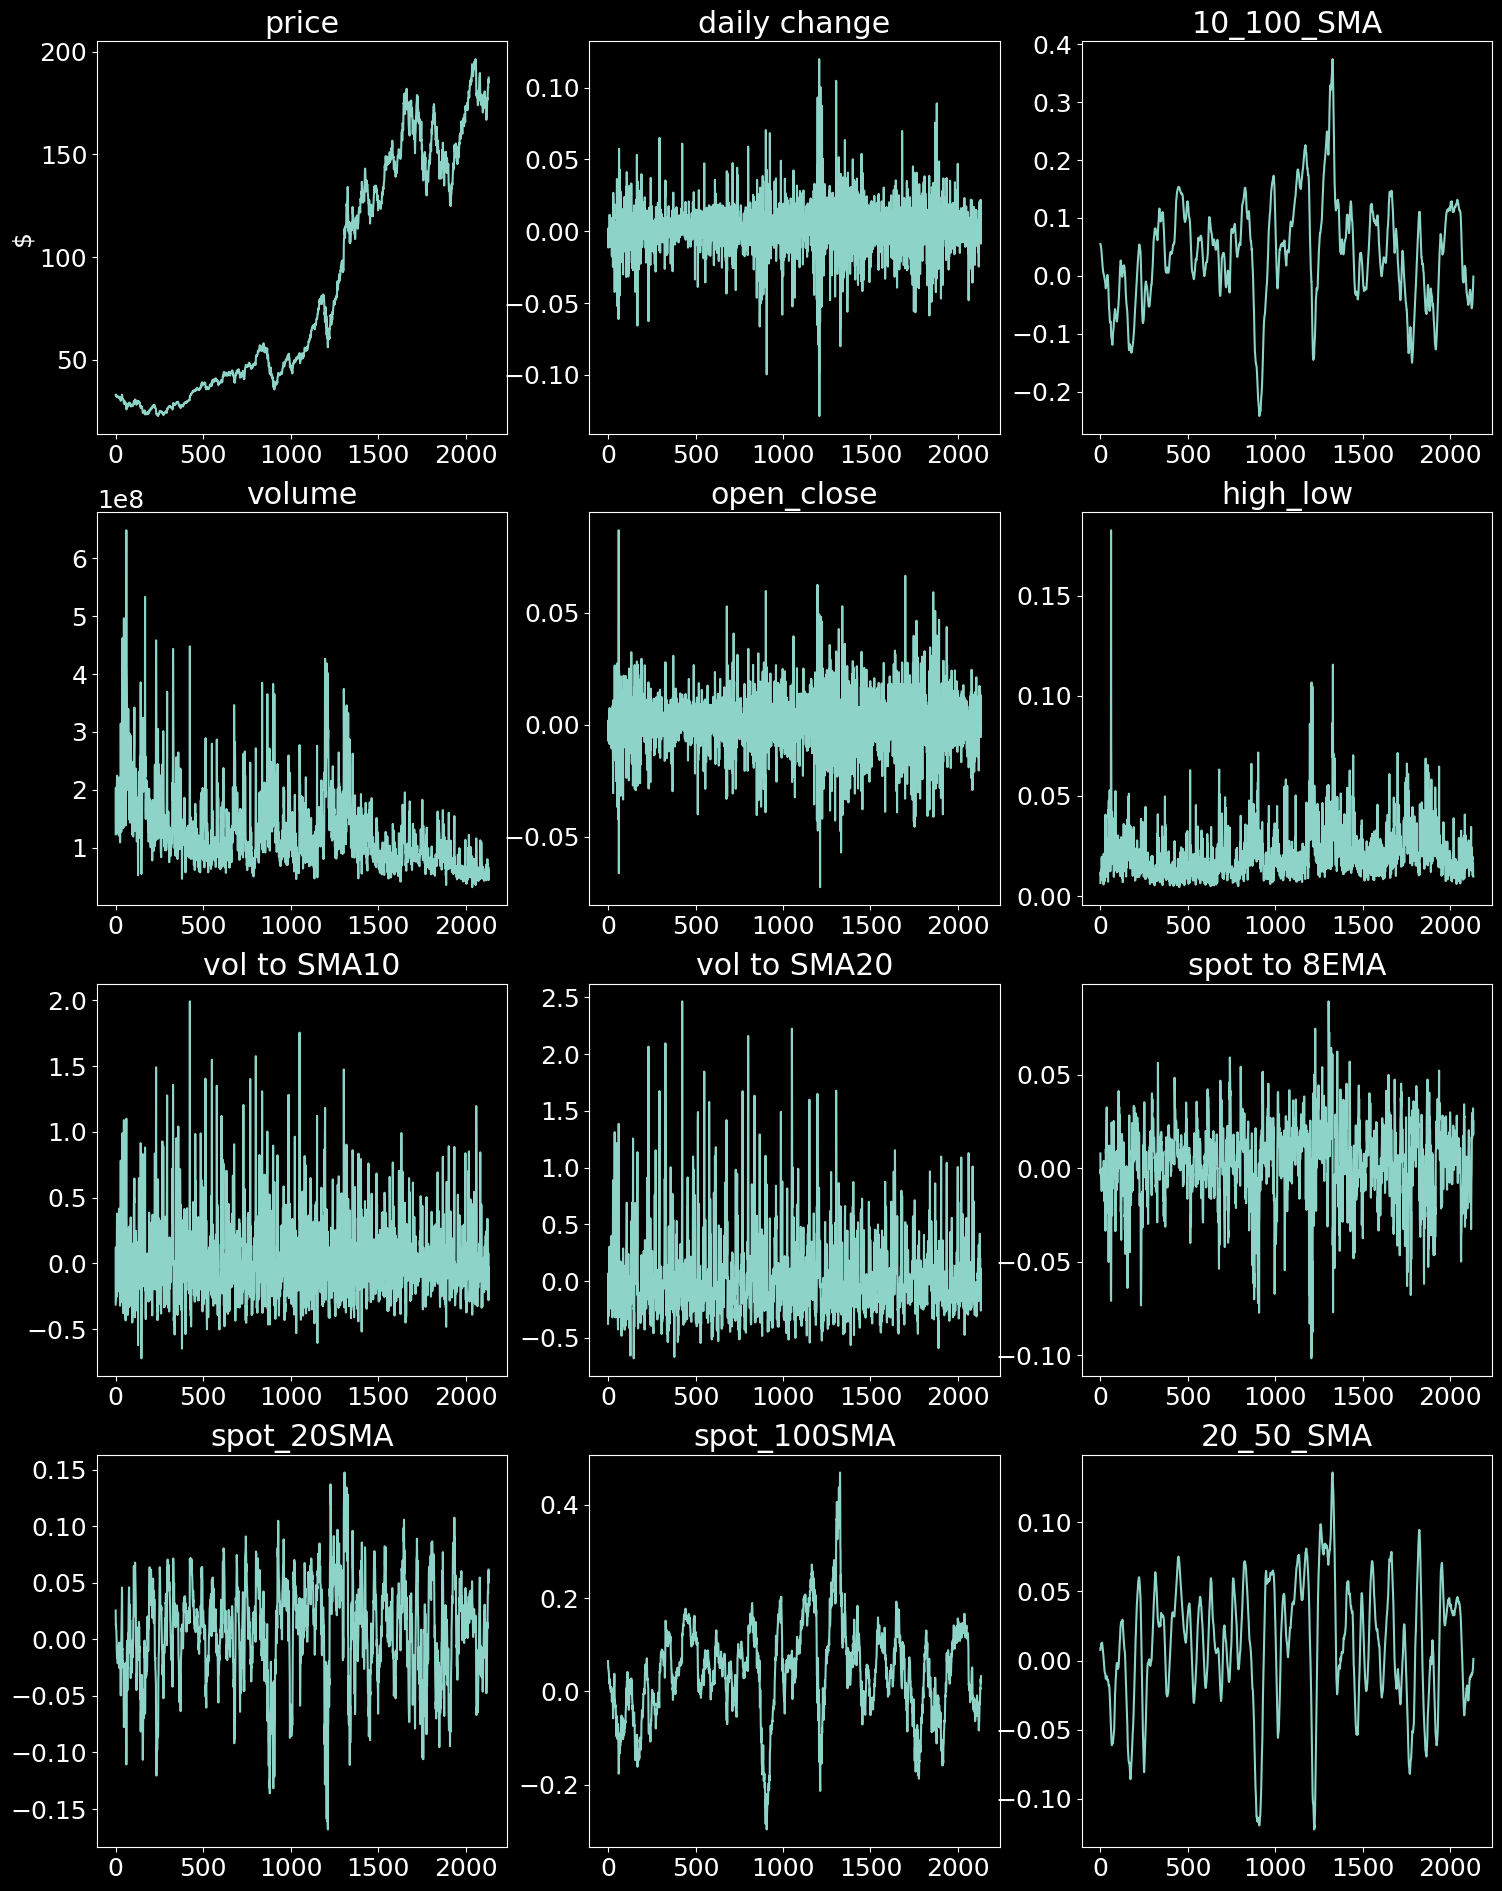

In [10]:
fig = plt.figure()
plt.figure(figsize=(18,14))

plt.subplot(4, 3, 1)
plt.plot(MAs.spot)
plt.ylabel('$')
plt.title('price')

plt.subplot(4, 3, 2)
plt.plot(MAs.pct_day)
plt.title('daily change')

plt.subplot(4, 3, 3)
plt.plot(MAs['10_100_SMA'])
plt.title('10_100_SMA')

plt.subplot(4, 3, 4)
plt.plot(MAs.vol)
plt.title('volume')
plt.subplots_adjust(top = 1.4)

plt.subplot(4, 3, 5)
plt.plot(MAs.open_close)
plt.title('open_close')

plt.subplot(4, 3, 6)
plt.plot(MAs.high_low)
plt.title('high_low')

plt.subplot(4, 3, 7)
plt.plot(MAs.v10)
plt.title('vol to SMA10')

plt.subplot(4, 3, 8)
plt.plot(MAs.v20)
plt.title('vol to SMA20')

plt.subplot(4, 3, 9)
plt.plot(MAs.spot_EMA)
plt.title('spot to 8EMA')

plt.subplot(4, 3, 10)
plt.plot(MAs.spot_20SMA)
plt.title('spot_20SMA')

plt.subplot(4, 3, 11)
plt.plot(MAs.spot_100SMA)
plt.title('spot_100SMA')

plt.subplot(4, 3, 12)
plt.plot(MAs['20_50_SMA'])
plt.title('20_50_SMA')
MAs.head(5)

# Creating a Benchmark

r2_score =  -0.8296565503330906


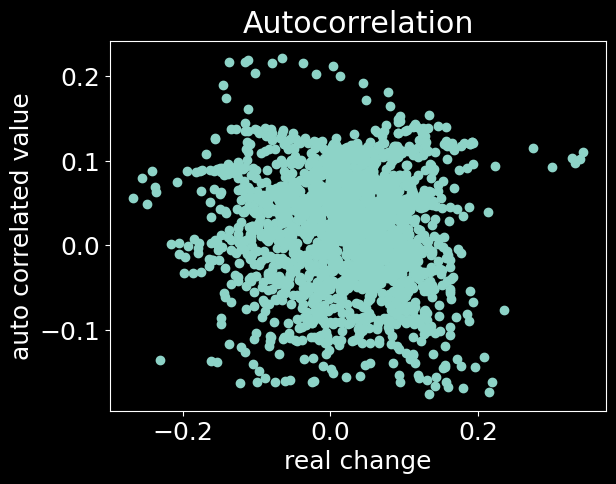

In [11]:
window_size = 1
look_forward =20
scaler = MinMaxScaler(feature_range=(0.00001, 1))
MAs_scaled = scaler.fit_transform(MAs)
x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward, 1)
MAs_array = MAs.values
x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)
y1, y2 = benchmark(y,look_forward)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation')
print('r2_score = ', r2_score(y1,y2))

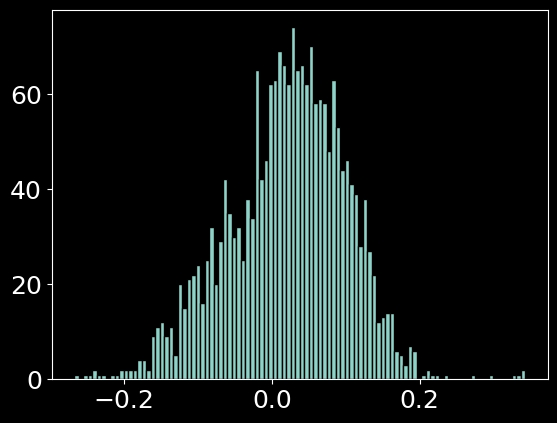

In [12]:
plt.hist(y1, bins = 100, edgecolor = 'black', histtype='bar');

# KNN Regression

In [13]:
train_ratio = 0.8
window_size = 1
look_forwards = [20]
batch_size = 16

look_forward_table, time_table, smape_test, smape_train, mae_train, mae_test = [], [], [], [], [], []
K_value, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

for look_forward in look_forwards:
    start_time = time.time()
    scaler = MinMaxScaler(feature_range=(0.00001, 1))
    MAs_scaled = scaler.fit_transform(MAs)
    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
    MAs_array = MAs.values
    x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

#split to train and CV
    x = x.reshape(len(x), -1)
    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

    for K in range(1,2):
        K = K+1
        K_value.append(K)
        model = neighbors.KNeighborsRegressor(n_neighbors = K)
        model.fit(x_train, y_train)
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
        smape_train.append(accuracy_train_smape)
        smape_test.append(accuracy_test_smape)
        mse_train.append(accuracy_train_mse)
        mse_test.append(accuracy_test_mse)
        r2_train.append(accuracy_train_r2)
        r2_test.append(accuracy_test_r2)
        mae_train.append(accuracy_train_mae)
        mae_test.append(accuracy_test_mae)
        end_time = time.time()
        time_table.append(round(end_time - start_time,2))
        look_forward_table.append(look_forward)


hyper_parameters = pd.DataFrame(list(zip(K_value,look_forward_table, time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['k', 'look_forward', 'time', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,k,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,2,20,0.06,52.8,146.28,0.0212,0.0795,0.00131,0.00958,0.74,-2.2


<Figure size 640x480 with 0 Axes>

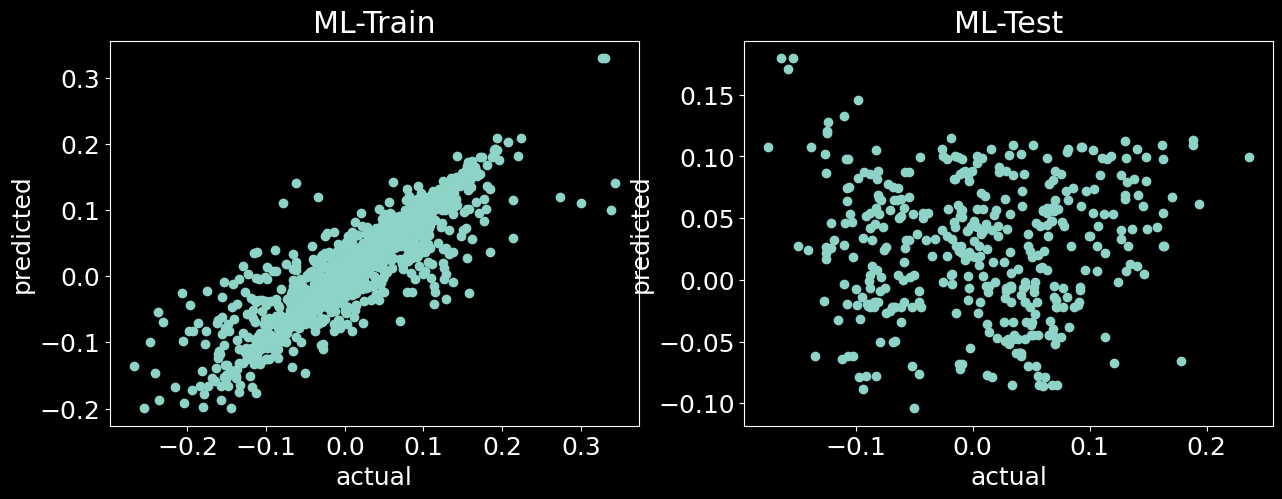

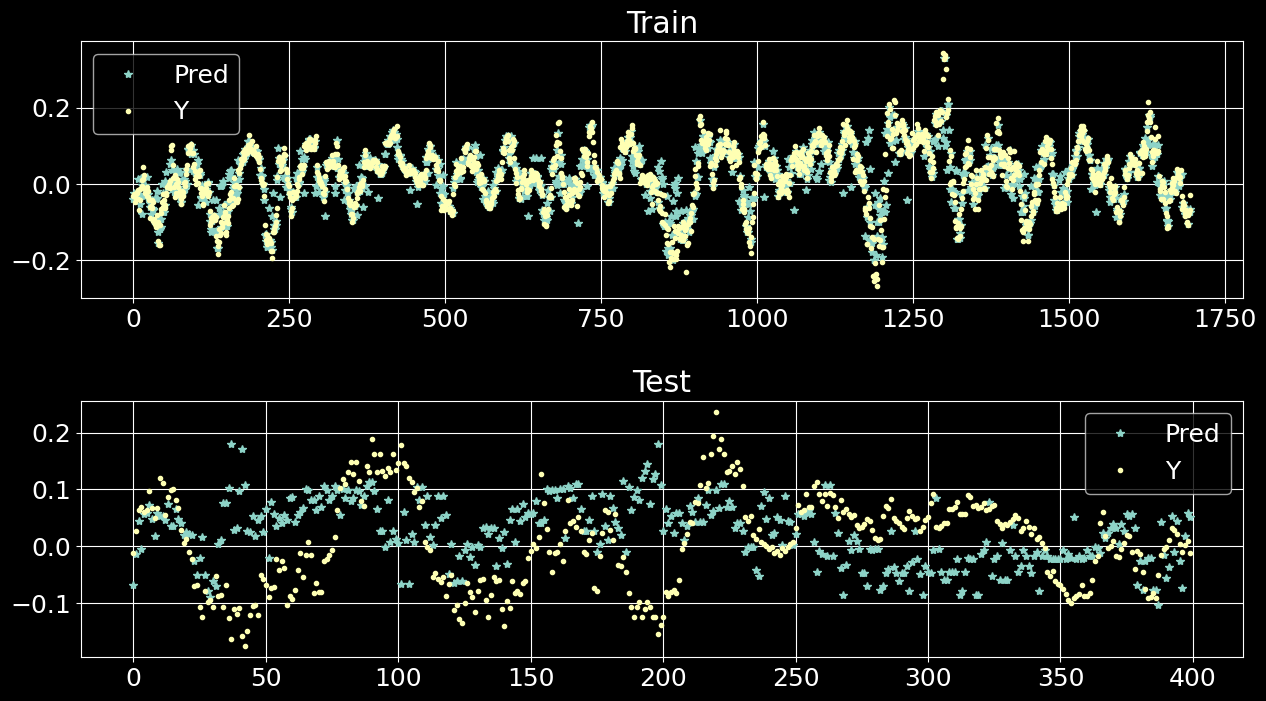

In [14]:
plot(y_train, prediction_train,y_test, prediction_test)

# KNN Classification

In [15]:
train_ratio = 0.8
window_size = 1
batch_size = 8

train = []
test = []
k = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

look_forwards = [20]

for look_forward in look_forwards:
    start_time = time.time()
    scaler = MinMaxScaler(feature_range=(0.00001, 1))
    MAs_scaled = scaler.fit_transform(MAs)
    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
    MAs_array = MAs.values
    x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
    y = y_classifier(y, 0.02)
    x = x.reshape(len(x), -1)
    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

    for K in range(58,59):
        K = K+1
        k.append(K)
        model = neighbors.KNeighborsClassifier(n_neighbors = K)
        model.fit(x_train, y_train)
        prediction_train = model.predict(x_train)
        prediction_test = model.predict(x_test)
        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
        long_precision =  rpt['long']['precision']
        long_fscore = rpt['long']['f1-score']
        cash_precision =  rpt['cash']['precision']
        short_precision =  rpt['short']['precision']
        long_rec =  rpt['long']['recall']
        cash_rec =  rpt['cash']['recall']
        short_rec =  rpt['short']['recall']
        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'],
                                     output_dict=True )
        long_precision_t =  rptt['long']['precision']
        cash_precision_t =  rptt['cash']['precision']
        short_precision_t =  rptt['short']['precision']
        long_rec_t =  rptt['long']['recall']
        cash_rec_t =  rptt['cash']['recall']
        short_rec_t =  rptt['short']['recall']
        long_prec.append(long_precision)
        cash_prec.append(cash_precision)
        short_prec.append(short_precision)
        long_recal.append(long_rec)
        cash_recal.append(cash_rec)
        short_recal.append(short_rec)
        long_prec_tr.append(long_precision_t)
        cash_prec_tr.append(cash_precision_t)
        short_prec_tr.append(short_precision_t)
        long_recal_tr.append(long_rec_t)
        cash_recal_tr.append(cash_rec_t)
        short_recal_tr.append(short_rec_t)
        long_fscores.append(long_fscore)

hyper_parameters = pd.DataFrame(list(zip(k, long_fscores, long_prec, cash_prec, short_prec, long_prec_tr,
cash_prec_tr, short_prec_tr )),columns =['K', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,K,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,59,0.489627,0.398649,0.0,0.267327,0.599709,0.526316,0.457746


In [16]:
hyper_parameters

,K,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,59,0.489627,0.398649,0.0,0.267327,0.599709,0.526316,0.457746


# KNN Test

In [17]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.27      0.19      0.22       140
        cash       0.00      0.00      0.00        82
        long       0.40      0.63      0.49       186

    accuracy                           0.36       408
   macro avg       0.22      0.28      0.24       408
weighted avg       0.27      0.36      0.30       408



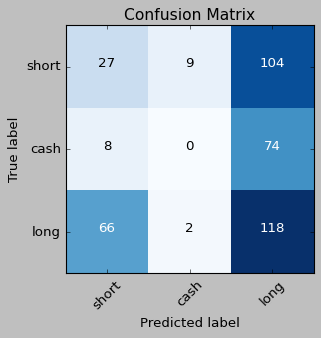

In [18]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# KNN Train:

In [19]:
rpt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.46      0.28      0.34       470
        cash       0.53      0.07      0.12       305
        long       0.60      0.89      0.72       921

    accuracy                           0.57      1696
   macro avg       0.53      0.41      0.39      1696
weighted avg       0.55      0.57      0.51      1696



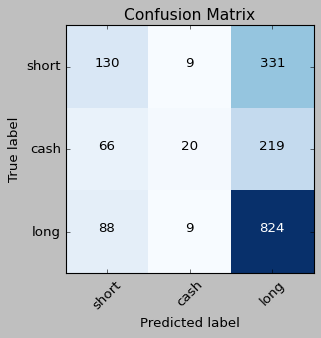

In [20]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train, prediction_train, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Classification for  Benchmark

In [21]:
window_size = 1
look_forward =20
train_ratio = 0.8
MAs_array = MAs.values
x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)
test_y = y[int(len(y)*train_ratio):,:]
y1, y2 = benchmark(test_y,look_forward)
y1, y2 = y_classifier(y1.reshape(-1,1), 0.02), y_classifier(y2.reshape(-1,1), 0.02)


In [22]:
rpt = classification_report(y1, y2, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.24      0.26      0.25       129
        cash       0.35      0.26      0.30        84
        long       0.49      0.52      0.50       170

    accuracy                           0.38       383
   macro avg       0.36      0.35      0.35       383
weighted avg       0.38      0.38      0.37       383



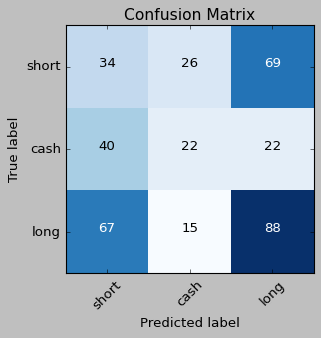

In [23]:
import itertools
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y1, y2, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# SVM Regressor

In [24]:
train_ratio = 0.8
batch_size = 8
kernels = ['poly']
look_forward = 20
window_size = 1
Cs = [5]
gammas = [4]
degrees = [3]
look_forwards = [20]
K, Ct, G, D, LF = [], [], [], [], []
time_table, epoch_table, epoch_table, smape_test,smape_train, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], [], [], [], [], [], [], []

for kernel in kernels:
    for c in Cs:
        for d in degrees:
            for g in gammas:
                for look_forward in look_forwards:
                    start_time = time.time()

                    scaler = MinMaxScaler(feature_range=(0.00001, 1))
                    MAs_scaled = scaler.fit_transform(MAs)
                    x, y_scaled = create_dataset_difference_gap(MAs_scaled, 1, look_forward,1)
                    MAs_array = MAs.values
                    x_scaled, y = create_dataset_difference_gap(MAs_array, 1, look_forward,1)
                    y = y.ravel()
                    x = x.reshape(len(x), -1)
                    x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

                    model = SVR(kernel = kernel, C = c, degree = d, gamma = g)
                    model.fit(x_train, y_train)
                    prediction_train = model.predict(x_train)
                    prediction_test = model.predict(x_test)
                    accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                    accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                    accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                    accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                    accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                    accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                    accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                    accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                    smape_train.append(accuracy_train_smape)
                    smape_test.append(accuracy_test_smape)
                    mse_train.append(accuracy_train_mse)
                    mse_test.append(accuracy_test_mse)
                    r2_train.append(accuracy_train_r2)
                    r2_test.append(accuracy_test_r2)
                    mae_train.append(accuracy_train_mae)
                    mae_test.append(accuracy_test_mae)
                    end_time = time.time()
                    time_table.append(round(end_time - start_time,2))
                    K.append(kernel)
                    Ct.append(c)
                    G.append(g)
                    D.append(d)
                    LF.append(look_forward)
                    print(round(end_time - start_time,2), kernel, c, g, d, look_forward)
hyper_parameters = pd.DataFrame(list(zip(K, Ct, G, D, LF, time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['kernel', 'C', 'gamma', 'degree', 'look_forward', 'time', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

10.43 poly 5 4 3 20


,kernel,C,gamma,degree,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,poly,5,4,3,20,10.43,99.3,142.2,3.1592,14.1899,28.28268,295.95855,-1.38,-1.61


In [25]:
hyper_parameters

,kernel,C,gamma,degree,look_forward,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,poly,5,4,3,20,10.43,99.3,142.2,3.1592,14.1899,28.28268,295.95855,-1.38,-1.61


<Figure size 640x480 with 0 Axes>

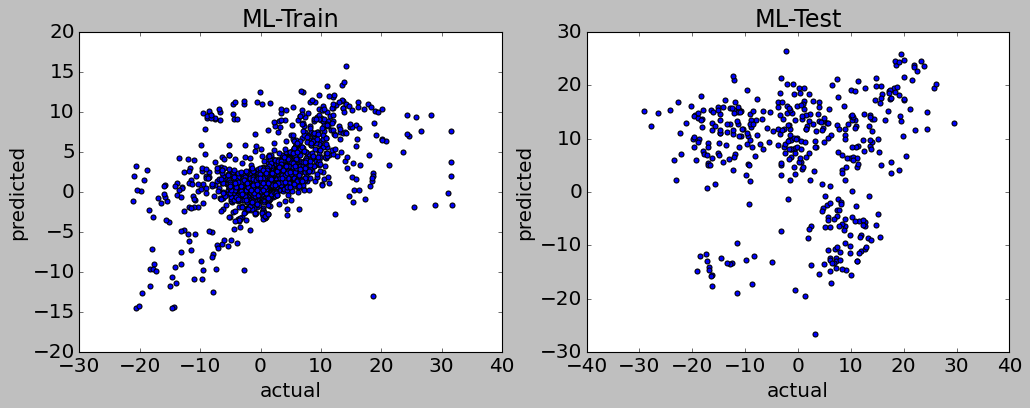

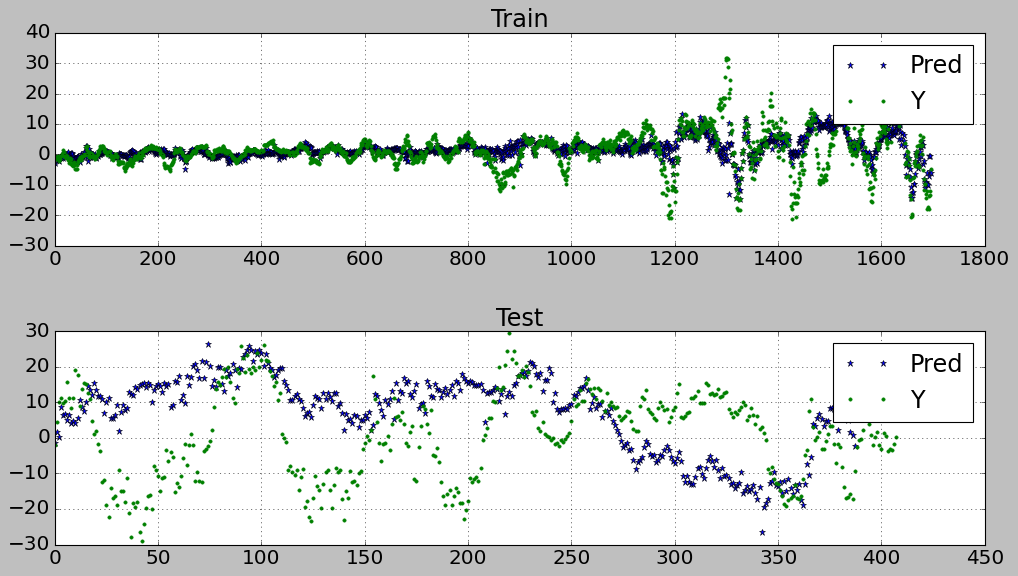

In [26]:
plot(y_train, prediction_train,y_test, prediction_test)

# SVM Classifier - has some issues

In [27]:
train_ratio = 0.8
batch_size = 8
kernels = ['poly']
Cs = [0.35]
gammas = [3.25]
degrees = [3]
look_forwards = [20]
K, Ct, G, D, LF = [], [], [], [], []
time_table = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

for kernel in kernels:
    for c in Cs:
        for d in degrees:
            for g in gammas:
                for look_forward in look_forwards:
                    start_time = time.time()
                    scaler = MinMaxScaler(feature_range=(0.00001, 1))
                    MAs_scaled = scaler.fit_transform(MAs)
                    x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                    MAs_array = MAs.values
                    x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                    y = y_classifier(y, 0.02)
                    #y = y.ravel()
                    x = x.reshape(len(x), -1)
                    x_train, y_train, x_test, y_test = test_train(x, y, batch_size, train_ratio)

                    model = SVC(kernel = kernel, C = c, degree = d, gamma = g)
                    model.fit(x_train, y_train)
                    prediction_train = model.predict(x_train)
                    prediction_test = model.predict(x_test)
                    rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                    long_precision =  rpt['long']['precision']
                    long_fscore = rpt['long']['f1-score']
                    cash_precision =  rpt['cash']['precision']
                    short_precision =  rpt['short']['precision']
                    long_rec =  rpt['long']['recall']
                    cash_rec =  rpt['cash']['recall']
                    short_rec =  rpt['short']['recall']
                    rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'],
                                                 output_dict=True )
                    long_precision_t =  rptt['long']['precision']
                    cash_precision_t =  rptt['cash']['precision']
                    short_precision_t =  rptt['short']['precision']
                    long_rec_t =  rptt['long']['recall']
                    cash_rec_t =  rptt['cash']['recall']
                    short_rec_t =  rptt['short']['recall']
                    long_prec.append(long_precision)
                    cash_prec.append(cash_precision)
                    short_prec.append(short_precision)
                    long_recal.append(long_rec)
                    cash_recal.append(cash_rec)
                    short_recal.append(short_rec)
                    long_prec_tr.append(long_precision_t)
                    cash_prec_tr.append(cash_precision_t)
                    short_prec_tr.append(short_precision_t)
                    long_recal_tr.append(long_rec_t)
                    cash_recal_tr.append(cash_rec_t)
                    short_recal_tr.append(short_rec_t)
                    long_fscores.append(long_fscore)
                    end_time = time.time()
                    time_table.append(round(end_time - start_time,2))
                    K.append(kernel)
                    Ct.append(c)
                    G.append(g)
                    D.append(d)
                    LF.append(look_forward)
                    print(round(end_time - start_time,2), kernel, c, g, d, look_forward, long_fscore)
hyper_parameters = pd.DataFrame(list(zip(K, Ct, G, D, LF, time_table, long_fscores, long_prec, cash_prec, short_prec, long_prec_tr,
cash_prec_tr, short_prec_tr )),
columns =['kernel', 'C', 'gamma', 'degree', 'look_forward', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

NameError: ignored

In [ ]:
hyper_parameters

In [ ]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

In [ ]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Random Forest Regresor

In [28]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [50], [100], [5], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl = [], [], [], []
time_table, smape_train, smape_test, mae_train, mae_test = [], [], [], [], []
mse_train, mse_test, r2_train, r2_test = [],[], [], []

for estimators in n_estimators:
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                scaler = MinMaxScaler(feature_range=(0.00001, 1))
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y.ravel()
                x = x.reshape(len(x), -1)
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestRegressor(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                smape_train.append(accuracy_train_smape)
                smape_test.append(accuracy_test_smape)
                mse_train.append(accuracy_train_mse)
                mse_test.append(accuracy_test_mse)
                r2_train.append(accuracy_train_r2)
                r2_test.append(accuracy_test_r2)
                mae_train.append(accuracy_train_mae)
                mae_test.append(accuracy_test_mae)
                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                n_estimatorsl.append(estimators)
                max_depthl.append(max_depth)
                min_samples_splitl.append(min_sample_split)
                min_samples_leafl.append(min_sample_leaf)

                print(round(end_time - start_time,2),estimators, max_depth, min_sample_split, min_sample_leaf,
                      accuracy_test_r2, accuracy_test_mse )
hyper_parameters = pd.DataFrame(list(zip(n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl
                                         , time_table, smape_train, smape_test, mae_train,
                                         mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['n_estimators',' max_depths', 'min_samples_split', 'min_samples_leaf', 'time', 'smape_train'
                  , 'smape_test','mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

1.16 50 100 5 4 -4.37 0.00851


,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,1.16,47.49,146.34,0.0189,0.0782,0.00075,0.00851,0.79,-4.37


In [29]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,1.16,47.49,146.34,0.0189,0.0782,0.00075,0.00851,0.79,-4.37


In [30]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,50,100,5,4,1.16,47.49,146.34,0.0189,0.0782,0.00075,0.00851,0.79,-4.37


<Figure size 640x480 with 0 Axes>

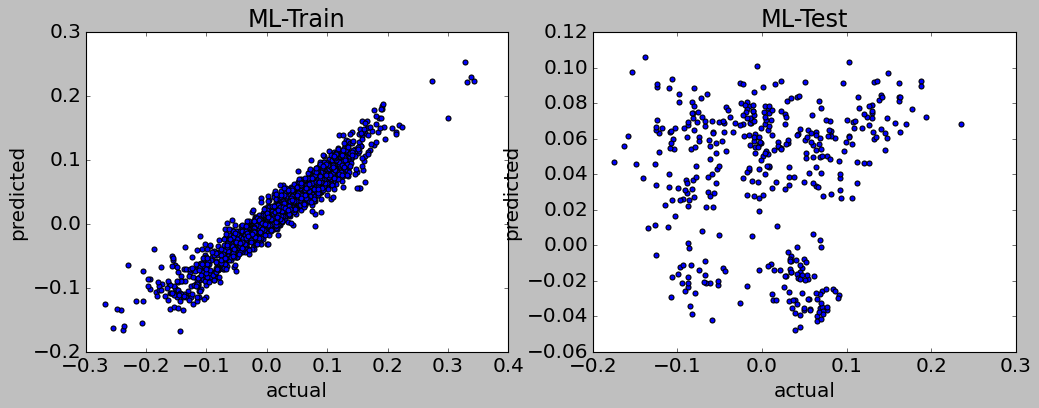

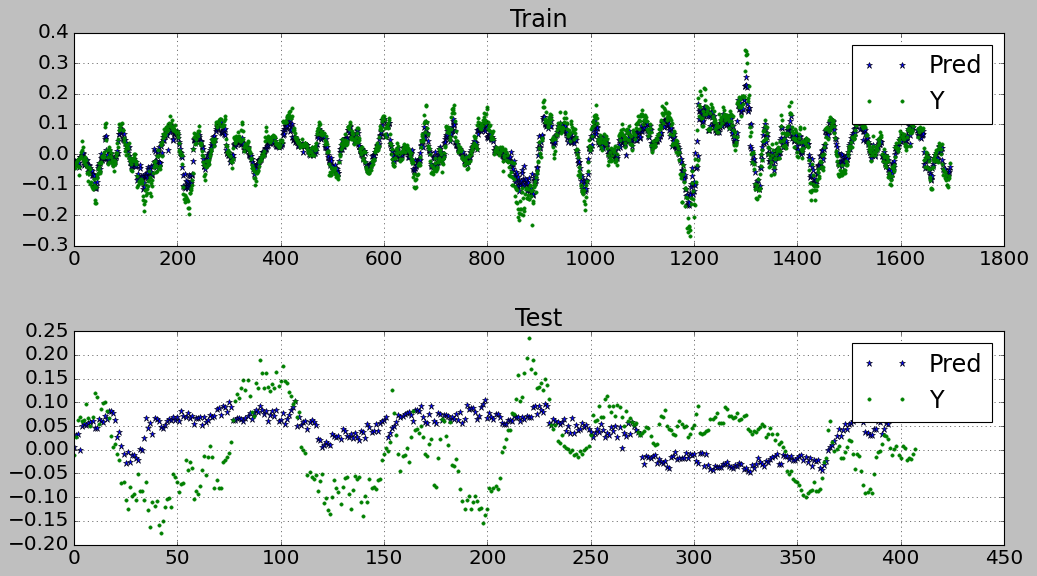

In [31]:
plot(y_train, prediction_train,y_test, prediction_test)

# Random Forest Classifier

In [32]:
train_ratio = 0.8
batch_size = 8
look_forward = 20
n_estimators, max_depths, min_samples_split, min_samples_leaf = [12], [40], [10], [4]
n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl, long_fscores = [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr =  [], [], [], [], []

for estimators in n_estimators:
    for max_depth in max_depths:
        for min_sample_split in min_samples_split:
            for min_sample_leaf in min_samples_leaf:
                start_time = time.time()
                scaler = MinMaxScaler(feature_range=(0.00001, 1))
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, 1, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, 1, look_forward,1)
                y = y_classifier(y, 0.02)
                x = x.reshape(len(x), -1)

                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)
                model = RandomForestClassifier(n_estimators = estimators, max_depth = max_depth,
                   min_samples_split = min_sample_split, min_samples_leaf = min_sample_leaf, random_state = 413)
                model.fit(x_train, y_train)
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'],
                                             output_dict=True )
                long_precision_t =  rptt['long']['precision']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_tr.append(long_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                n_estimatorsl.append(estimators)
                max_depthl.append(max_depth)
                min_samples_splitl.append(min_sample_split)
                time_table.append(round(end_time - start_time,2))
                min_samples_leafl.append(min_sample_leaf)
                print(round(end_time - start_time,2),estimators, max_depth, min_sample_split, min_sample_leaf,
                      long_fscore)
hyper_parameters = pd.DataFrame(list(zip(n_estimatorsl, max_depthl, min_samples_splitl, min_samples_leafl
, time_table,long_fscores, long_prec, cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr  )),
columns =['n_estimators',' max_depths', 'min_samples_split', 'min_samples_leaf', 'time', 'long_fscore_test',
'long_prec','cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

-22.38 12 40 10 4 0.49895178197064993


,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,12,40,10,4,1.16,0.498952,0.408935,0.060606,0.309524,0.90239,0.92562,0.942222


In [33]:
hyper_parameters

,n_estimators,max_depths,min_samples_split,min_samples_leaf,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,12,40,10,4,1.16,0.498952,0.408935,0.060606,0.309524,0.90239,0.92562,0.942222


In [34]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'] )
print(rpt)

              precision    recall  f1-score   support

       short       0.31      0.19      0.23       140
        cash       0.06      0.02      0.03        82
        long       0.41      0.64      0.50       186

    accuracy                           0.36       408
   macro avg       0.26      0.28      0.26       408
weighted avg       0.30      0.36      0.31       408



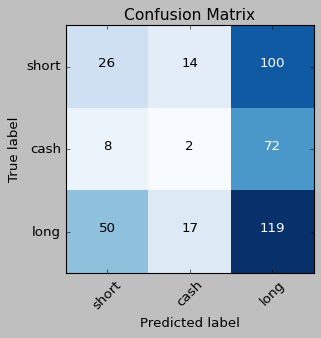

In [35]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test, prediction_test, classes= ['short', 'cash', 'long'],
                         normalize=False, title='Confusion Matrix')

# Neural Net Regressor

In [43]:
!pip install rasa==1.1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.2/447.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 11.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rasa to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following versions that require a different python version: 1.10.10 Requires-Python >=3.6,<3.8; 1.10.11 Requires-Python >=3.6,<3.8; 1.10.12 Requires-Python >=3.6,<3.8; 1.10.13 Requires-Python >=3.6,<3.8; 1.10.14 Requires-Python >=3.6,<3.8; 1.10.15 Requires-Python >=3.6,<3.8; 1.10.16 Requires-Python >=3.6,<3.8; 1.10.17 Requires-Python >=3.6,<3.8; 1

In [49]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot

1 out of 12 units = 10 lr = 3e-07 batch_size = 32 epoch = 300
12/12 [==============================] - 0s 2ms/step
0.5177 0.3579 45.51


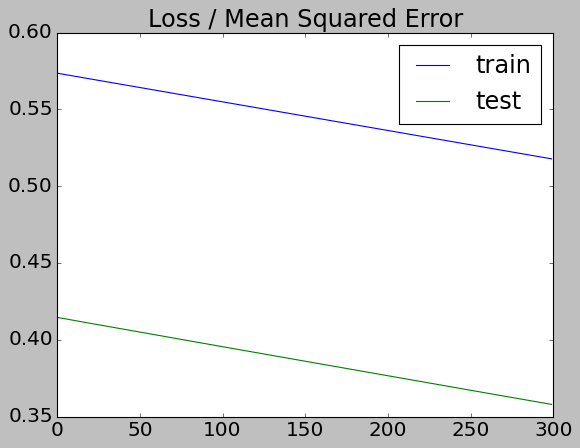

2 out of 12 units = 10 lr = 3e-07 batch_size = 128 epoch = 300
2/2 [==============================] - 0s 5ms/step
0.6486 0.5715 21.52


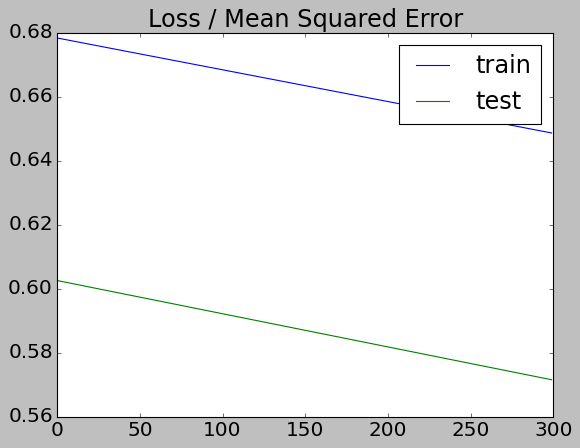

3 out of 12 units = 10 lr = 3e-05 batch_size = 32 epoch = 300
12/12 [==============================] - 0s 2ms/step
0.0677 0.0757 41.84


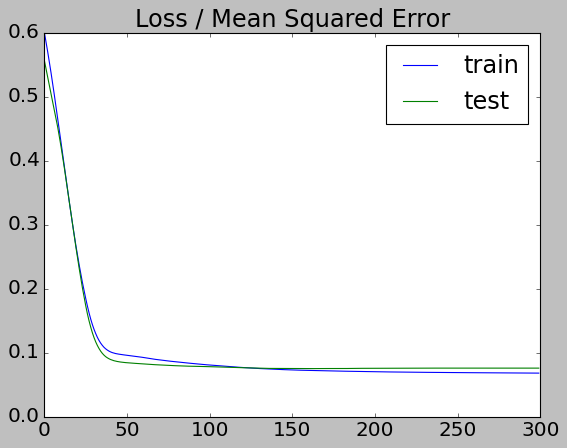

4 out of 12 units = 10 lr = 3e-05 batch_size = 128 epoch = 300
2/2 [==============================] - 0s 4ms/step
0.0736 0.0684 16.43


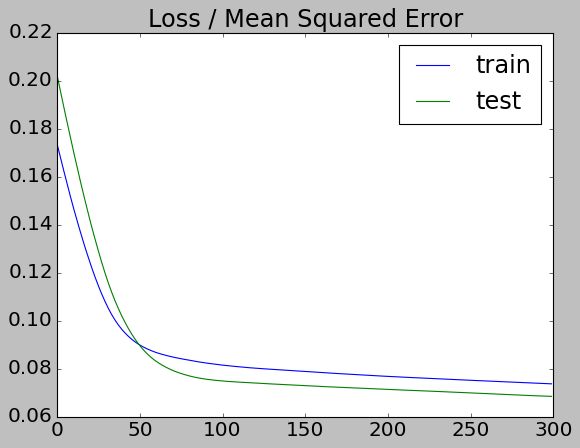

5 out of 12 units = 20 lr = 3e-07 batch_size = 32 epoch = 300
12/12 [==============================] - 0s 2ms/step
0.2461 0.1655 41.85


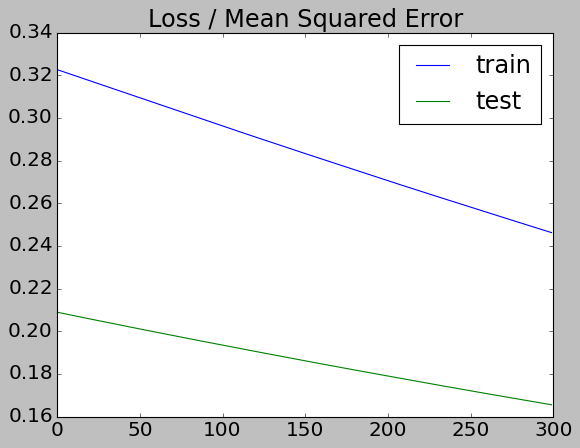

6 out of 12 units = 20 lr = 3e-07 batch_size = 128 epoch = 300
2/2 [==============================] - 0s 4ms/step
0.2948 0.2632 17.12


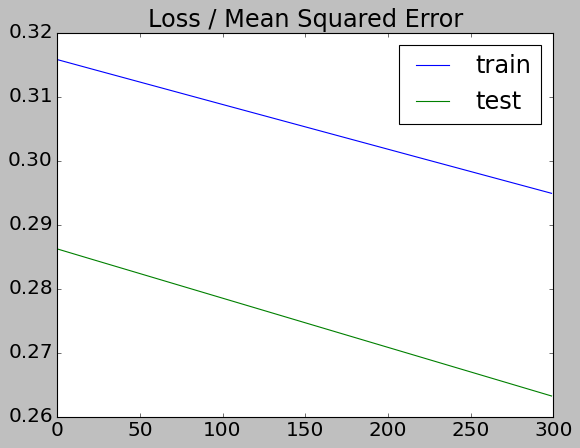

7 out of 12 units = 20 lr = 3e-05 batch_size = 32 epoch = 300
12/12 [==============================] - 0s 2ms/step
0.0618 0.0786 38.66


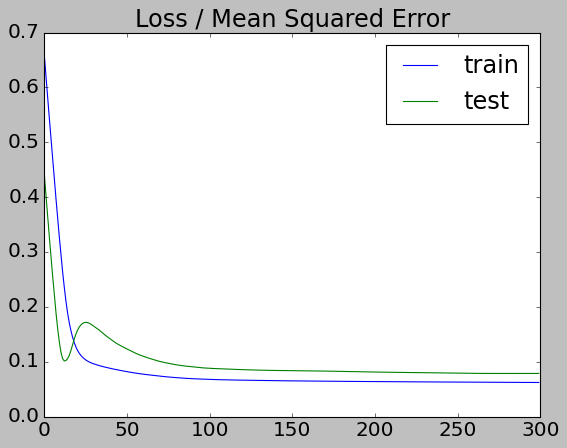

8 out of 12 units = 20 lr = 3e-05 batch_size = 128 epoch = 300
2/2 [==============================] - 0s 5ms/step
0.0714 0.0694 21.68


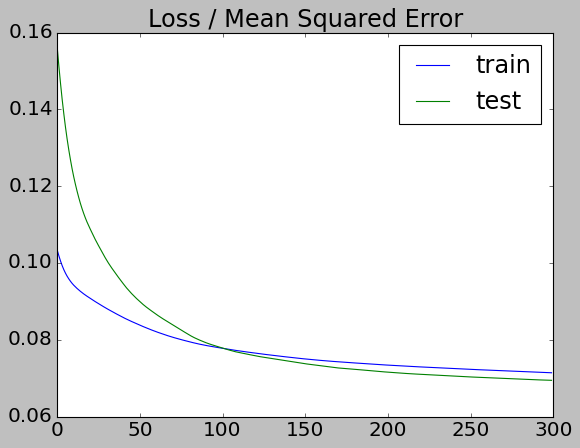

9 out of 12 units = 40 lr = 3e-07 batch_size = 32 epoch = 300
12/12 [==============================] - 0s 2ms/step
0.0779 0.0844 37.88


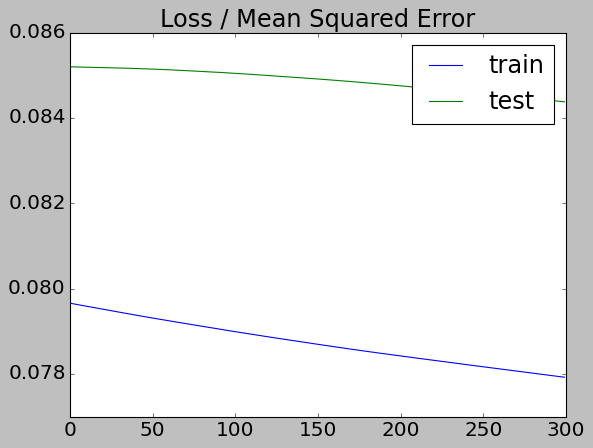

10 out of 12 units = 40 lr = 3e-07 batch_size = 128 epoch = 300
2/2 [==============================] - 0s 8ms/step
0.0835 0.0874 21.53


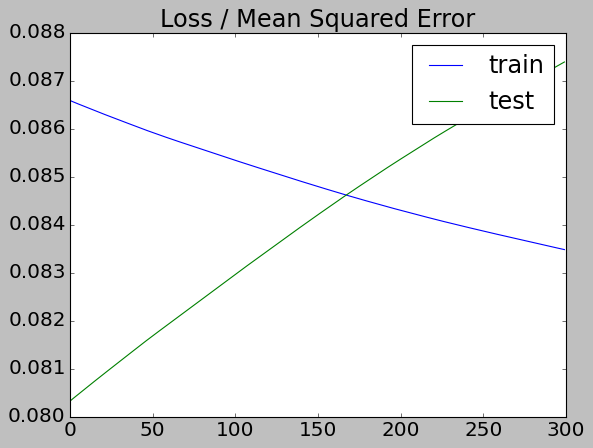

11 out of 12 units = 40 lr = 3e-05 batch_size = 32 epoch = 300
12/12 [==============================] - 0s 2ms/step
0.0615 0.0714 37.81


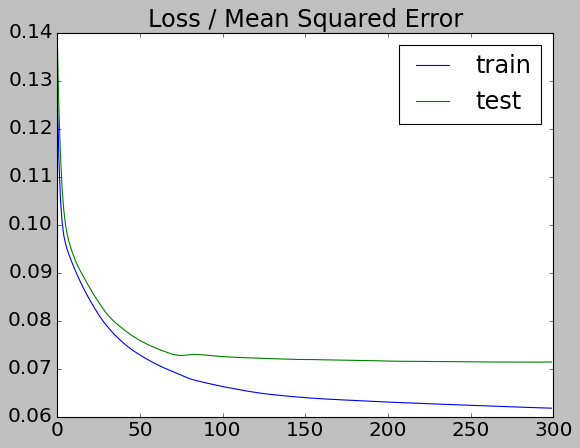

12 out of 12 units = 40 lr = 3e-05 batch_size = 128 epoch = 300
2/2 [==============================] - 0s 6ms/step
0.0642 0.0658 16.97


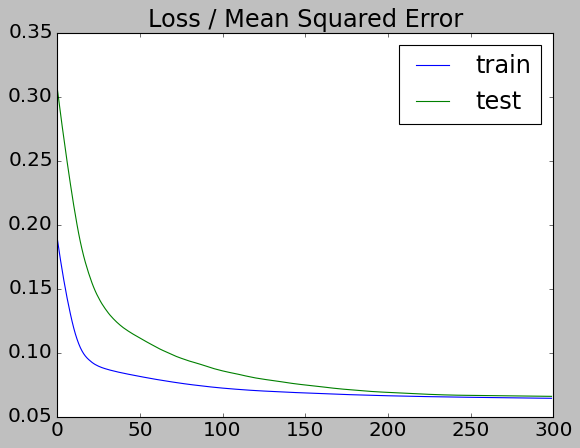

    unit            lr  batch_size   time  smape_train  smape_test  mae_train  \
0     10  3.000000e-05         128  16.43       136.50      114.32     0.0736   
1     40  3.000000e-07         128  21.53       145.28      126.12     0.0835   
2     10  3.000000e-05          32  41.84       130.70      131.93     0.0677   
3     40  3.000000e-05          32  37.81       123.81      136.19     0.0615   
4     20  3.000000e-05          32  38.66       126.07      137.00     0.0618   
5     20  3.000000e-05         128  21.68       137.83      138.42     0.0714   
6     20  3.000000e-07          32  41.85       148.07      151.57     0.2461   
7     20  3.000000e-07         128  17.12       155.50      153.64     0.2948   
8     40  3.000000e-07          32  37.88       144.04      155.49     0.0779   
9     40  3.000000e-05         128  16.97       134.38      161.08     0.0642   
10    10  3.000000e-07          32  45.51       170.72      166.25     0.5177   
11    10  3.000000e-07      

In [52]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot

# Assuming other necessary custom functions like create_dataset_percentage_gap, test_train_split,
# smape, mse, mae, and r2_score are defined elsewhere in your script.

# Define the seed for reproducibility
seed_value = 0

def fix_rnd_Keras():
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Your predefined variables
train_ratio = 0.8
window_size = 1
look_forward = 20

# Tables to store the results
unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table, smape_test, smape_train, mae_train = [], [], [], [], []
mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

# Hyperparameters
Units = [10, 20, 40]
lrs = [0.0000003, 0.00003]
batch_sizes = [32, 128]
epochs = 300
counter = 0

# Main loop
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            total = len(Units) * len(lrs) * len(batch_sizes)
            counter += 1
            start_time = time.time()

            # Fixing random seed for reproducibility
            fix_rnd_Keras()

            # Add your data preprocessing here
            # MAs should be defined and filled with data before this code block

            scaler = MinMaxScaler(feature_range=(0.00001, 1))
            MAs_scaled = scaler.fit_transform(MAs)
            x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward, 1)
            MAs_array = MAs.values
            x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward, 1)

            x = x.reshape(len(x), -1)
            x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

            # Define the model architecture
            model = Sequential()
            model.add(Dense(units=units, activation='relu'))
            model.add(Dense(units=1))
            opt = Adam(learning_rate=lr)
            model.compile(loss='mae', optimizer=opt)

            # Train the model
            history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

            # Logging
            print(counter, 'out of', total, 'units =', units, 'lr =', lr,
                  'batch_size =', batch_size, 'epoch =', epochs)

            # Store hyperparameters and results
            unit_table.append(units)
            lr_table.append(lr)
            batch_size_table.append(batch_size)

            # Predictions and accuracy calculations
            prediction_train = model.predict(x_train, batch_size=batch_size)
            prediction_test = model.predict(x_test, batch_size=batch_size)

            # You need to define these metrics functions or import them if they are custom
            accuracy_train_smape = round(smape(prediction_train, y_train), 2)
            accuracy_test_smape = round(smape(prediction_test, y_test), 2)
            accuracy_train_mse = round(mse(prediction_train, y_train), 5)
            accuracy_test_mse = round(mse(prediction_test, y_test), 5)
            accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
            accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
            accuracy_train_mae = round(mae(prediction_train, y_train), 4)
            accuracy_test_mae = round(mae(prediction_test, y_test), 4)

            # Append the results to the tables
            smape_train.append(accuracy_train_smape)
            smape_test.append(accuracy_test_smape)
            mse_train.append(accuracy_train_mse)
            mse_test.append(accuracy_test_mse)
            r2_train.append(accuracy_train_r2)
            r2_test.append(accuracy_test_r2)
            mae_train.append(accuracy_train_mae)
            mae_test.append(accuracy_test_mae)

            end_time = time.time()
            time_table.append(round(end_time - start_time, 2))

            # Output the performance
            print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time, 2)))

            # Plotting the loss
            pyplot.title('Loss / Mean Squared Error')
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            pyplot.show()

# Create a DataFrame for hyperparameters
hyper_parameters = pd.DataFrame(list(zip(unit_table, lr_table, batch_size_table,
                                         time_table, smape_train, smape_test, mae_train, mae_test,
                                         mse_train, mse_test, r2_train, r2_test)),
                                columns=['unit', 'lr', 'batch_size', 'time', 'smape_train', 'smape_test',
                                         'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])

# Sort the DataFrame based on a performance metric
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)

# Display the sorted DataFrame
print(hyper_parameters)


In [ ]:
hyper_parameters

In [53]:
hyper_parameters

,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,3.000000e-05,128,16.43,136.50,114.32,0.0736,0.0684,0.00916,0.00801,-3.09,-1.38
1,40,3.000000e-07,128,21.53,145.28,126.12,0.0835,0.0874,0.01072,0.01079,-1.67,-4.16
2,10,3.000000e-05,32,41.84,130.70,131.93,0.0677,0.0757,0.00783,0.00880,-3.90,-7.18
3,40,3.000000e-05,32,37.81,123.81,136.19,0.0615,0.0714,0.00652,0.00761,-10.22,-14.17
4,20,3.000000e-05,32,38.66,126.07,137.00,0.0618,0.0786,0.00670,0.00991,-4.45,-4.95
5,20,3.000000e-05,128,21.68,137.83,138.42,0.0714,0.0694,0.00838,0.00726,-4.35,-2.14
6,20,3.000000e-07,32,41.85,148.07,151.57,0.2461,0.1655,0.08262,0.03928,-2.94,-2.36
7,20,3.000000e-07,128,17.12,155.50,153.64,0.2948,0.2632,0.10217,0.07985,-6.24,-12.55
8,40,3.000000e-07,32,37.88,144.04,155.49,0.0779,0.0844,0.00960,0.01076,-2.83,-2.83
9,40,3.000000e-05,128,16.97,134.38,161.08,0.0642,0.0658,0.00675,0.00614,-30.95,-17.31


<Figure size 640x480 with 0 Axes>

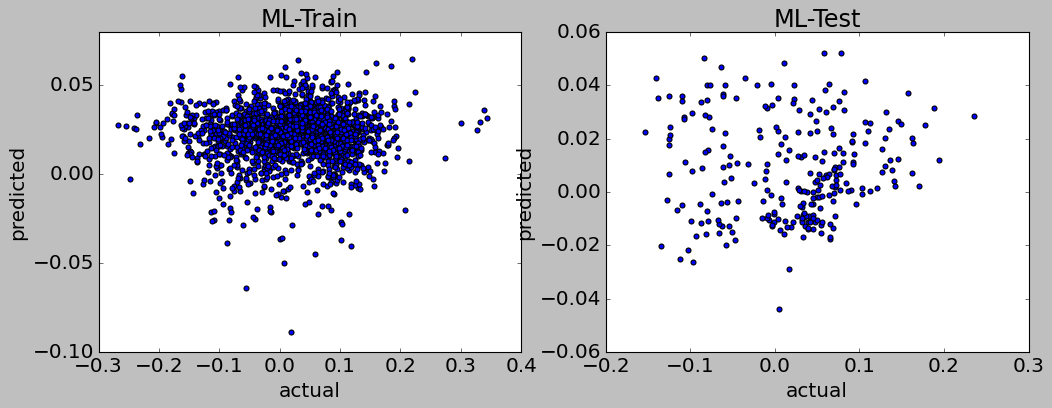

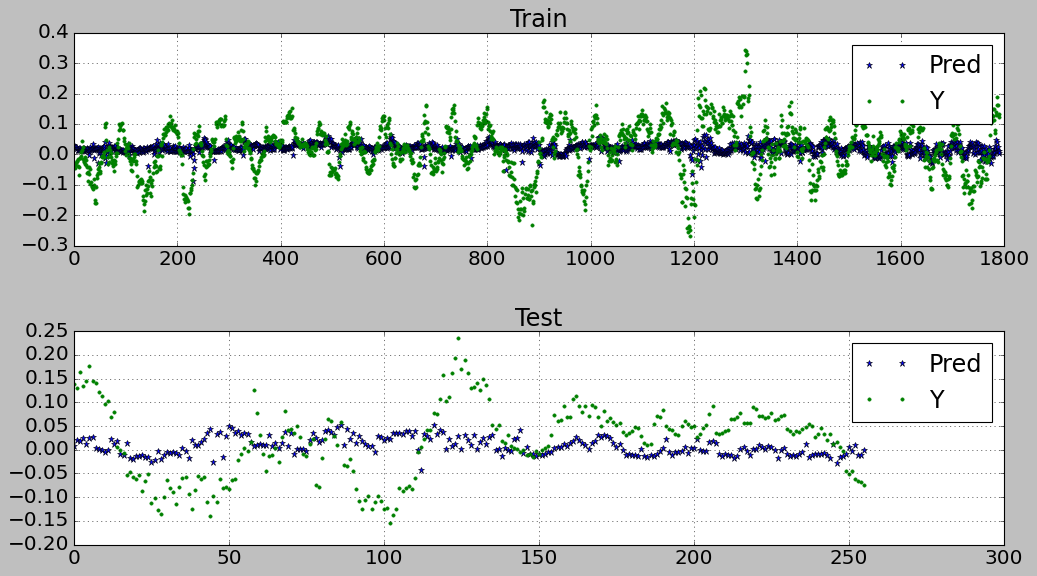

In [54]:
plot(y_train, prediction_train,y_test, prediction_test) # 1 layer, 20 units, drop out, 2000 epochs

# Neural Net Classifier

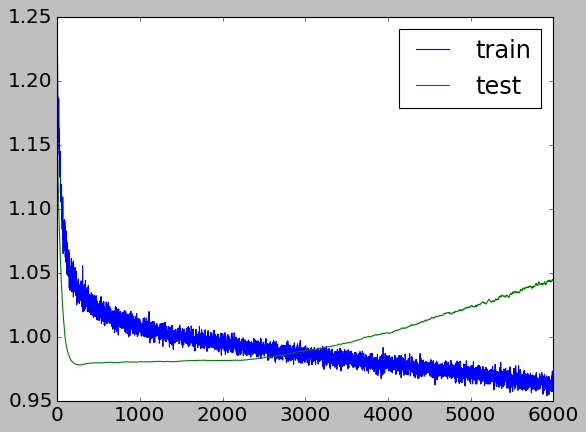

8/8 [==============================] - 0s 3ms/step
326.03 1 out of  1 units =  40 lr =  3e-05 batch_size =  256 epoch =  6000 long prec =  0.5246913580246914 fscore =  0.5555555555555556


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,40,6000,0.00003,256,326.03,0.555556,0.524691,0.0,0.297872,0.559666,0.0,0.594828


In [56]:
train_ratio = 0.8
window_size = 1
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table = [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

Units = [40]
lrs = [ 0.00003]
batch_sizes = [256]
epoch = [6000]
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                total = len(Units)*len(lrs)*len(batch_sizes)* len(epoch)
                counter += 1
                start_time = time.time()
                #fixing rnd
                fix_rnd_Keras()

                scaler = MinMaxScaler(feature_range=(0.00001, 1))
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                y = y_classifier(y, 0.02)
                y = y_softmax(y)
                x = x.reshape(len(x), -1)
                x_train, y_train, x_test, y_test = test_train_split(x, y, batch_size, train_ratio)

                model = Sequential()
                model.add(Dense(units = units, activation = 'relu'))
                model.add(Dropout(0.5))
                model.add(Dense(units = units, activation = 'relu'))
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                opt = Adam(learning_rate = lr)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                    epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='test')
                pyplot.legend()
                pyplot.show()
                unit_table.append(units)
                lr_table.append(lr)
                batch_size_table.append(batch_size)
                prediction_train = model.predict(x_train)
                prediction_test = model.predict(x_test)
                y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                            output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'],
                                             output_dict=True )
                long_precision_t =  rptt['long']['precision']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_tr.append(long_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                epoch_table.append(epochs)

                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                print(round(end_time - start_time,2), counter, 'out of ', total, 'units = ', units, 'lr = ', lr,
    'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)

hyper_parameters = pd.DataFrame(list(zip(unit_table, epoch_table, lr_table, batch_size_table, time_table, long_fscores, long_prec,
            cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr )),
            columns =['unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters


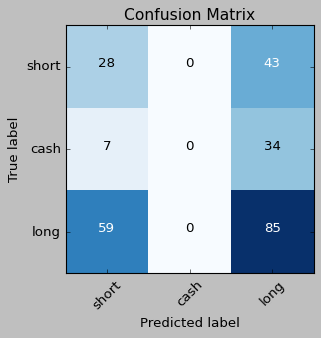

In [57]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [58]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.30      0.39      0.34        71
        cash       0.00      0.00      0.00        41
        long       0.52      0.59      0.56       144

    accuracy                           0.44       256
   macro avg       0.27      0.33      0.30       256
weighted avg       0.38      0.44      0.41       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train confusion

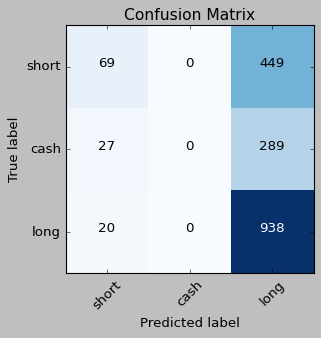

In [60]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_train,prediction_train, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [62]:
rpt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.59      0.13      0.22       518
        cash       0.00      0.00      0.00       316
        long       0.56      0.98      0.71       958

    accuracy                           0.56      1792
   macro avg       0.38      0.37      0.31      1792
weighted avg       0.47      0.56      0.44      1792



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM Regressor

1 out of  1 units =  10 lr =  6e-07 look_forward = 20 window_size = 20 batch_size =  32 epoch =  80
12/12 [==============================] - 0s 3ms/step
0.153 0.1312 102.1


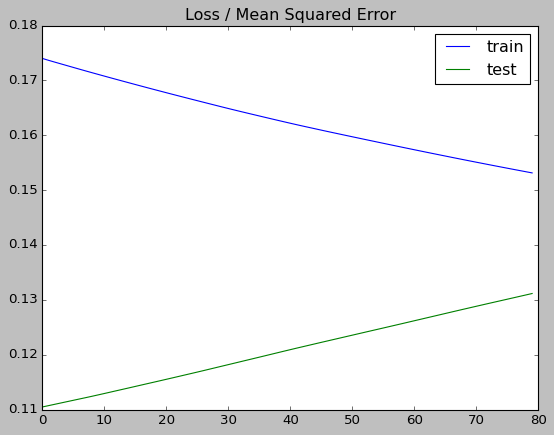

,unit,lr,window_size,batch_size,time,epoch,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,6.000000e-07,20,32,102.1,80,157.65,136.88,0.153,0.1312,0.0317,0.02448,-0.97,-8.62


In [64]:
train_ratio = 0.8

unit_table = []
lr_table = []
batch_size_table = []

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table, smape_test, smape_train, mae_train, window_size_table = [], [], [], [], [], []
mae_test, mse_train, mse_test, r2_train, r2_test = [], [], [], [], []

Units = [ 10]
lrs = [ 0.0000006]
look_forwards = [20]
window_sizes = [20]
batch_sizes = [32]
Epochs = [80]
counter = 0
for units in Units:
    for lr in lrs:
        for look_forward in look_forwards:
            for window_size in window_sizes:
                for batch_size in batch_sizes:
                    for epochs in Epochs:
                        total = len(Units)*len(lrs)*len(look_forwards)*len(window_sizes)*len(batch_sizes)
                        counter += 1
                        start_time = time.time()

                        fix_rnd_Keras()
                        scaler = MinMaxScaler(feature_range=(0.00001, 1))
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2]),
                        stateful=True))#, return_sequences = True))
                        #model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2])
                        #,stateful=True))

                        model.add(Dense(units = 1))
                        opt = Adam(learning_rate = lr)
                        model.compile(loss = 'mae', optimizer = opt)
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                            epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                        print(counter, 'out of ', total, 'units = ', units, 'lr = ', lr, 'look_forward =', look_forward,
                              'window_size =', window_size, 'batch_size = ', batch_size, 'epoch = ', epochs)

                        unit_table.append(units)
                        lr_table.append(lr)
                        window_size_table.append(window_size)
                        batch_size_table.append(batch_size)
                        epoch_table.append(epochs)

                        prediction_train = model.predict(x_train, batch_size=batch_size)
                        prediction_test = model.predict(x_test, batch_size=batch_size)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
                        pyplot.title('Loss / Mean Squared Error')
                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()

hyper_parameters = pd.DataFrame(list(zip(unit_table,lr_table,window_size_table,batch_size_table,
    time_table, epoch_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['unit','lr','window_size','batch_size','time', 'epoch', 'smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_train'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

<Figure size 640x480 with 0 Axes>

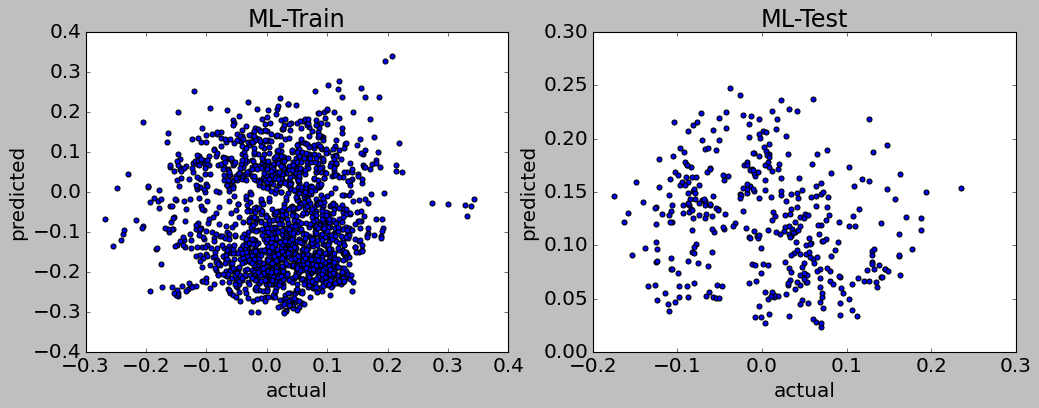

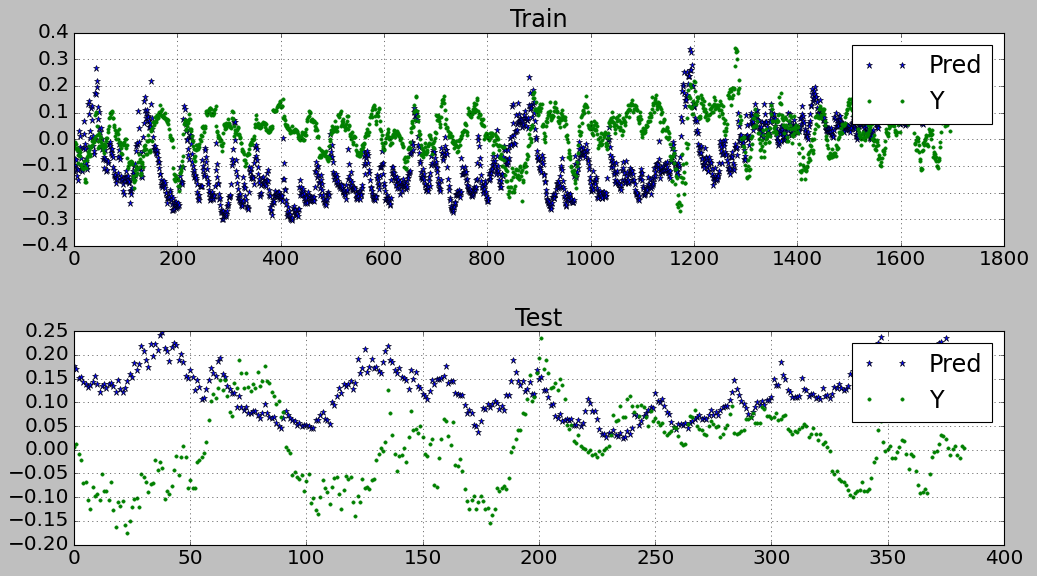

In [66]:
plot(y_train, prediction_train,y_test, prediction_test)

In [65]:
prediction_train = model.predict(x_train, batch_size=batch_size)
prediction_test = model.predict(x_test, batch_size=batch_size)


12/12 [==============================] - 0s 3ms/step


In [67]:
# After the model has been trained and you have obtained predictions
print("Predicted prices on the training set:")
print(prediction_train.flatten())

print("Predicted prices on the test set:")
print(prediction_test.flatten())


Predicted prices on the training set:
[-0.0958242  -0.11758093 -0.10070087 ...  0.17904373  0.18175653
  0.16796085]
Predicted prices on the test set:
[0.17767149 0.17002274 0.15121207 0.15363511 0.14219844 0.1381317
 0.13207918 0.1363493  0.14335327 0.15648854 0.1378844  0.12180904
 0.13376893 0.13919309 0.13101506 0.13807918 0.14127004 0.13521622
 0.12219089 0.14682561 0.1291485  0.12203102 0.13022314 0.14603503
 0.15930507 0.15438232 0.18367231 0.1691592  0.18124232 0.21911603
 0.20846221 0.19024856 0.17514591 0.22409424 0.19863787 0.22264735
 0.2103334  0.24124973 0.24784777 0.21541378 0.20759368 0.18756765
 0.21606424 0.22476569 0.22122191 0.18918353 0.20185223 0.1856401
 0.15566067 0.15118195 0.1686498  0.15286314 0.1259583  0.14795716
 0.13234621 0.10747857 0.10838275 0.12723203 0.14634413 0.17305267
 0.16181618 0.15609159 0.18751656 0.1941134  0.16072688 0.15251346
 0.13378634 0.12816474 0.11875596 0.12054143 0.09051464 0.11398877
 0.09013335 0.08465175 0.09052791 0.0778982  0.

# LSTM Classify

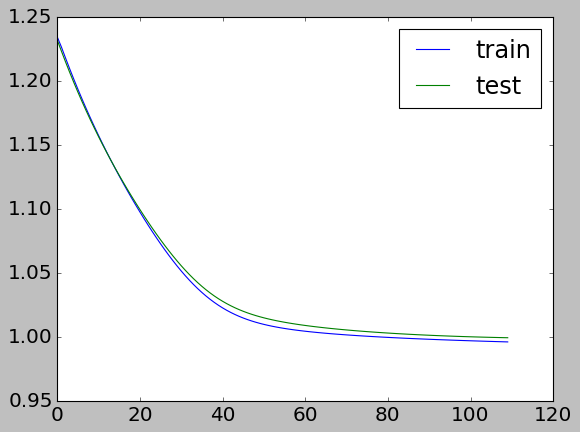

1/1 [==============================] - 0s 19ms/step
11.56 1 out of  1 units =  10 lr =  0.0001 batch_size =  256 epoch =  110 long prec =  0.52734375 fscore =  0.690537084398977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,fscore_train,cash_prec_train,short_prec_train
0,10,110,0.0001,256,11.56,0.690537,0.527344,0.0,0.0,0.700979,0.0,0.0


In [68]:
train_ratio = 0.8
window_size = 10
look_forward =20

unit_table = []
lr_table = []
batch_size_table = []
time_table, epoch_table = [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_trf =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []

Units = [10]
lrs = [ 0.0001]
batch_sizes = [256]
epoch = [110]
counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                total = len(Units)*len(lrs)*len(batch_sizes)* len(epoch)
                counter += 1
                start_time = time.time()
                #fixing rnd
                fix_rnd_Keras()

                scaler = MinMaxScaler(feature_range=(0.00001, 1))
                MAs_scaled = scaler.fit_transform(MAs)
                x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                MAs_array = MAs.values
                x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                y = y_classifier(y, 0.02)
                y = y_softmax(y)

                train_length = int(len(x)*train_ratio)

                for i in range(train_length, train_length+batch_size):
                    remainder = i%batch_size
                    if remainder == 0:
                        train_length = i
                        break
                x_train = x[:train_length,:]
                y_train = y[:train_length,]

                for i in range(len(x)-batch_size, len(x)):
                    remainder = i%batch_size
                    if remainder == 0:
                        train_length_test = i
                        break
                x_test = x[train_length:train_length_test,:]
                y_test = y[train_length:train_length_test,]

                model = Sequential()
                model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2]),
                               stateful=True))#, return_sequences = True))
                #model.add(LSTM(units = units, batch_input_shape=(batch_size, window_size, x_train.shape[2])
                #,stateful=True))
                model.add(Dense(3, activation='softmax'))
                opt = Adam(learning_rate = lr)
                model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                    epochs = epochs, batch_size = batch_size, verbose = 0, shuffle=False)

                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='test')
                pyplot.legend()
                pyplot.show()
                unit_table.append(units)
                lr_table.append(lr)
                batch_size_table.append(batch_size)
                prediction_train = model.predict(x_train, batch_size=batch_size)
                prediction_test = model.predict(x_test, batch_size=batch_size)
                y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                            output_dict=True )
                long_precision =  rpt['long']['precision']
                long_fscore = rpt['long']['f1-score']
                cash_precision =  rpt['cash']['precision']
                short_precision =  rpt['short']['precision']
                long_rec =  rpt['long']['recall']
                cash_rec =  rpt['cash']['recall']
                short_rec =  rpt['short']['recall']
                rptt = classification_report(y_train, prediction_train, target_names = ['short', 'cash', 'long'],
                                             output_dict=True )
                longf_precision_t =  rptt['long']['f1-score']
                cash_precision_t =  rptt['cash']['precision']
                short_precision_t =  rptt['short']['precision']
                long_rec_t =  rptt['long']['recall']
                cash_rec_t =  rptt['cash']['recall']
                short_rec_t =  rptt['short']['recall']
                long_prec.append(long_precision)
                cash_prec.append(cash_precision)
                short_prec.append(short_precision)
                long_recal.append(long_rec)
                cash_recal.append(cash_rec)
                short_recal.append(short_rec)
                long_prec_trf.append(longf_precision_t)
                cash_prec_tr.append(cash_precision_t)
                short_prec_tr.append(short_precision_t)
                long_recal_tr.append(long_rec_t)
                cash_recal_tr.append(cash_rec_t)
                short_recal_tr.append(short_rec_t)
                long_fscores.append(long_fscore)
                epoch_table.append(epochs)

                end_time = time.time()
                time_table.append(round(end_time - start_time,2))
                print(round(end_time - start_time,2), counter, 'out of ', total, 'units = ', units, 'lr = ', lr,
    'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)

hyper_parameters = pd.DataFrame(list(zip(unit_table, epoch_table, lr_table, batch_size_table, time_table, long_fscores, long_prec,
            cash_prec, short_prec, long_prec_trf, cash_prec_tr, short_prec_tr )),
            columns =['unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'fscore_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters


              precision    recall  f1-score   support

       short       0.00      0.00      0.00        80
        cash       0.00      0.00      0.00        41
        long       0.53      1.00      0.69       135

    accuracy                           0.53       256
   macro avg       0.18      0.33      0.23       256
weighted avg       0.28      0.53      0.36       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


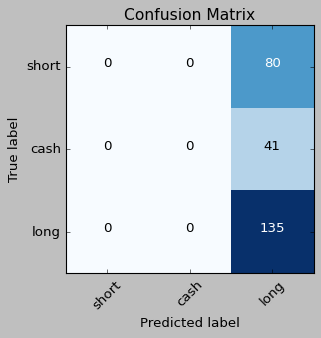

In [69]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

# CNN Regressor

1 out of  1 filters =  10 units =  160 lr =  3e-05 batch_size =  64 epoch =  100
12/12 [==============================] - 0s 2ms/step
0.0577 0.068 42.76


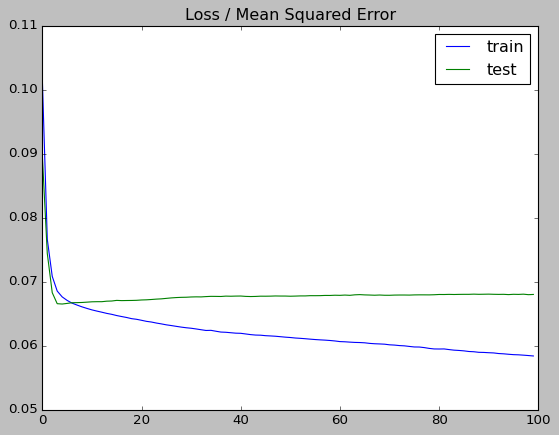

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 10)            660       
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 10)            510       
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 10)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense_45 (Dense)            (None, 160)               16160     
                                                                 
 dense_46 (Dense)            (None, 1)                 161       
                                                     

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,160,0.00003,64,42.76,114.9,143.26,0.0577,0.068,0.00605,0.00678,-9.8,-13.83


In [70]:
train_ratio = 0.8
window_size = 40
look_forward =20

unit_table = []
lr_table = []
look_forward_table = []
window_size_table = []
batch_size_table = []
filter_table, kernel_size_table = [], []
time_table = []
epoch_table = []
smape_train = []
smape_test = []
mae_train = []
mae_test = []
mse_train = []
mse_test = []
r2_train =[]
r2_test = []

Units = [ 160]
lrs = [ 0.00003]
batch_sizes = [64]
epoch = [100]
Filters = [10]
kernel_sizes = [5]

counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                for kernel_size in kernel_sizes:
                    for filters in Filters:
                        total = len(Units)*len(lrs)*len(batch_sizes)*len(epoch)*len(kernel_sizes)*len(Filters)
                        counter += 1
                        start_time = time.time()
                        #fixing rnd
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1))
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        #just for dense ANN, remove this for lstm
                        #x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
                                         input_shape = (window_size, x_train.shape[2])))
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu'))
                        model.add(MaxPooling1D(pool_size = 3))
                        model.add(Flatten())
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dense(units = 1))
                        opt = Adam(learning_rate = lr)
                        model.compile(loss = 'mae', optimizer = opt)
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                            epochs = epochs, verbose = 0, shuffle=False)

                        print(counter, 'out of ', total, 'filters = ', filters, 'units = ', units, 'lr = ', lr,
                              'batch_size = ', batch_size, 'epoch = ', epochs)

                        unit_table.append(units)
                        lr_table.append(lr)
                        batch_size_table.append(batch_size)

                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        filter_table.append(filters)
                        kernel_size_table.append(kernel_size)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(accuracy_train_mae, accuracy_test_mae, (round(end_time - start_time,2)))
                        pyplot.title('Loss / Mean Squared Error')
                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()

hyper_parameters = pd.DataFrame(list(zip(filter_table, kernel_size_table, unit_table,lr_table,batch_size_table,
    time_table, smape_train, smape_test, mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)),
        columns =['filter', 'kernel', 'unit','lr','batch_size','time','smape_train', 'smape_test',
                  'mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
model.summary()
hyper_parameters

In [71]:
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,160,0.00003,64,42.76,114.9,143.26,0.0577,0.068,0.00605,0.00678,-9.8,-13.83


In [72]:
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,160,0.00003,64,42.76,114.9,143.26,0.0577,0.068,0.00605,0.00678,-9.8,-13.83


In [ ]:
hyper_parameters

In [ ]:
hyper_parameters

In [73]:
hyper_parameters = hyper_parameters.sort_values(by=['mae_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,filter,kernel,unit,lr,batch_size,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,10,5,160,0.00003,64,42.76,114.9,143.26,0.0577,0.068,0.00605,0.00678,-9.8,-13.83


(0.0, 900.0, -0.1, 0.1)

<Figure size 640x480 with 0 Axes>

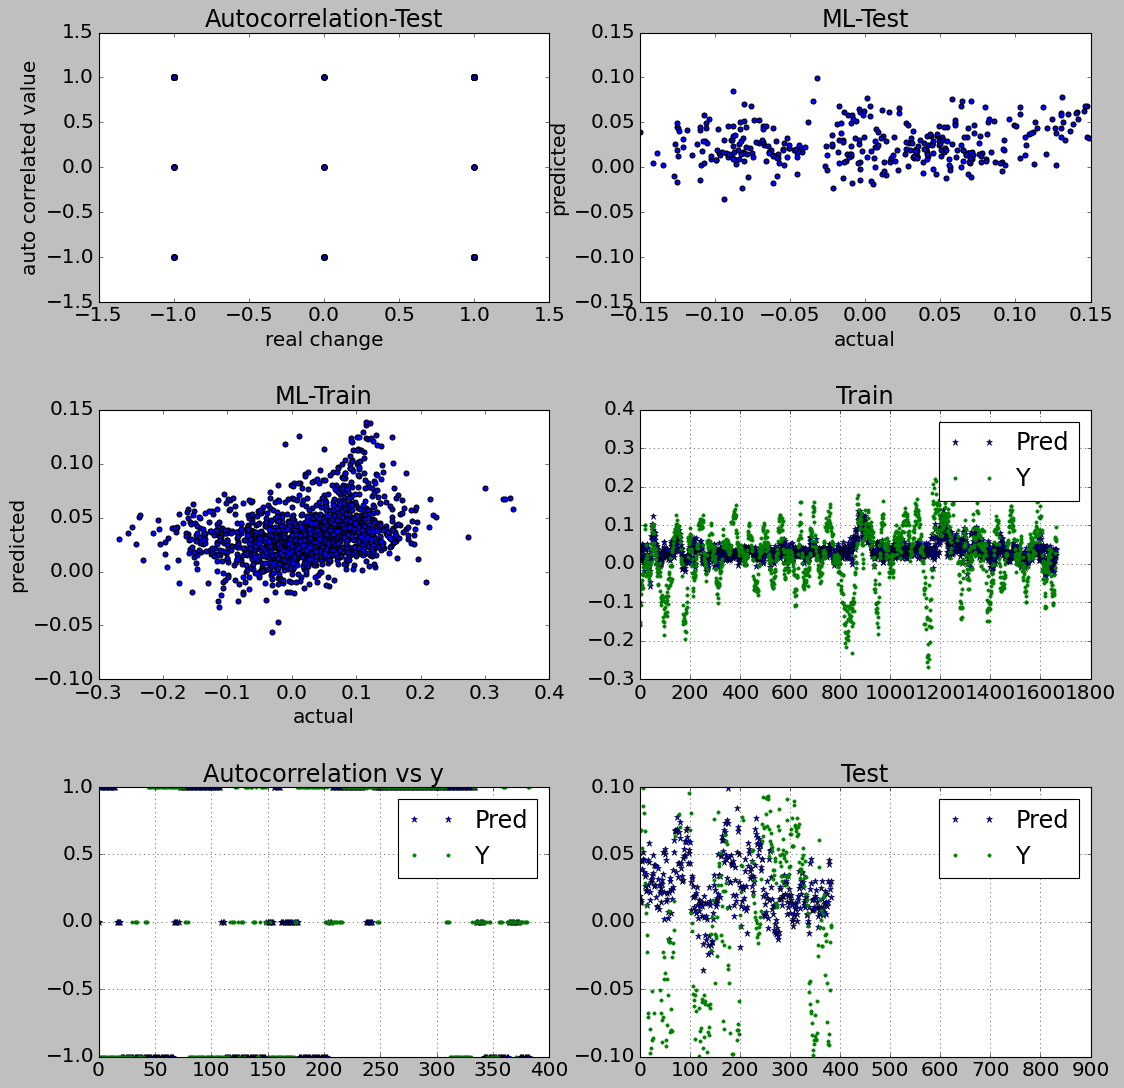

In [74]:
fig = plt.figure()
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(hspace = 0.4)
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation-Test')
plt.subplots_adjust(hspace = 0.4)

plt.subplot(3, 2, 2)
plt.scatter(y_test, prediction_test)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Test')
plt.axis([-0.15, 0.15, -0.15, 0.15])

plt.subplot(3, 2, 3)
plt.scatter(y_train, prediction_train)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Train')

plt.subplot(3, 2, 4)
plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Train')

plt.subplot(3, 2, 5)
plt.plot(y2, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y1, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Autocorrelation vs y')

plt.subplot(3, 2, 6)
plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
plt.grid()
plt.legend()
plt.title('Test')
plt.axis([0, 900, -0.1, 0.1])

# CNN Classifier

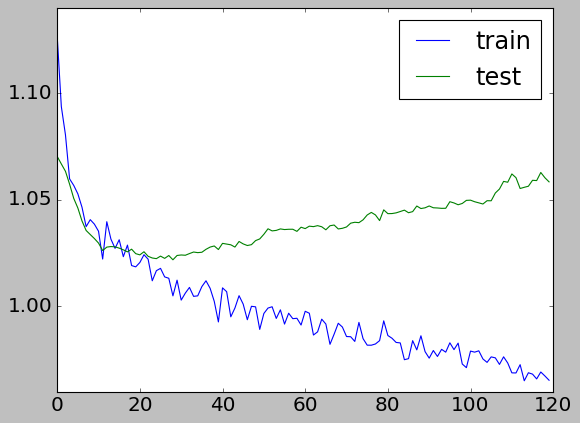

1/1 [==============================] - 0s 18ms/step
42.49 filters = 24 kernel = 8 1 out of  1 units =  40 lr =  9e-05 batch_size =  256 epoch =  120 long prec =  0.515625 fscore =  0.6804123711340206
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 13, 24)            2520      
                                                                 
 dropout_4 (Dropout)         (None, 13, 24)            0         
                                                                 
 flatten_1 (Flatten)         (None, 312)               0         
                                                                 
 dense_47 (Dense)            (None, 40)                12520     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,8,24,40,120,0.00009,256,42.49,0.680412,0.515625,0.0,0.0,0.541295,0.0,0.0


In [75]:
train_ratio = 0.8
window_size = 20
look_forward =20

unit_table = []
lr_table = []
look_forward_table = []
window_size_table = []
batch_size_table = []
filter_table, kernel_size_table = [], []
time_table = []
epoch_table = []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr =  [],[],[],[],[],[],[]
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []



Units = [40]
lrs = [ 0.00009]
batch_sizes = [ 256]
epoch = [120]
Filters = [24]
kernel_sizes = [8]

counter = 0
for units in Units:
    for lr in lrs:
        for batch_size in batch_sizes:
            for epochs in epoch:
                for kernel_size in kernel_sizes:
                    for filters in Filters:
                        total = len(Units)*len(lrs)*len(batch_sizes)*len(epoch)*len(kernel_sizes)*len(Filters)
                        counter += 1
                        start_time = time.time()
                        #fixing rnd
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1))
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                        y = y_classifier(y, 0.02)
                        y = y_softmax(y)
                        #just for dense ANN, remove this for lstm
                        #x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,:]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,:]

                        model = Sequential()
                        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
                                         input_shape = (window_size, x_train.shape[2])))
                        model.add(Dropout(0.5))
                        #model.add(MaxPooling1D(pool_size = 3))
                        model.add(Flatten())
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dropout(0.5))
                        model.add(Dense(units = units, activation='relu'))
                        model.add(Dropout(0.5))

                        model.add(Dense(3, activation='softmax'))
                        opt = Adam(learning_rate = lr)
                        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
                        history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                                            epochs = epochs, verbose = 0, shuffle=False)

                        pyplot.plot(history.history['loss'], label='train')
                        pyplot.plot(history.history['val_loss'], label='test')
                        pyplot.legend()
                        pyplot.show()
                        unit_table.append(units)
                        lr_table.append(lr)
                        batch_size_table.append(batch_size)
                        prediction_train = model.predict(x_train, batch_size=batch_size)
                        prediction_test = model.predict(x_test, batch_size=batch_size)
                        y_train, y_test, prediction_train, prediction_test = desoftmaxer(y_train), desoftmaxer(y_test),desoftmaxer(prediction_train), desoftmaxer(prediction_test)
                        rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'],
                                                    output_dict=True )
                        long_precision =  rpt['long']['precision']
                        long_fscore = rpt['long']['f1-score']
                        cash_precision =  rpt['cash']['precision']
                        short_precision =  rpt['short']['precision']
                        long_rec =  rpt['long']['recall']
                        cash_rec =  rpt['cash']['recall']
                        short_rec =  rpt['short']['recall']
                        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'],
                                                     output_dict=True )
                        long_precision_t =  rptt['long']['precision']
                        cash_precision_t =  rptt['cash']['precision']
                        short_precision_t =  rptt['short']['precision']
                        long_rec_t =  rptt['long']['recall']
                        cash_rec_t =  rptt['cash']['recall']
                        short_rec_t =  rptt['short']['recall']
                        long_prec.append(long_precision)
                        cash_prec.append(cash_precision)
                        short_prec.append(short_precision)
                        long_recal.append(long_rec)
                        cash_recal.append(cash_rec)
                        short_recal.append(short_rec)
                        long_prec_tr.append(long_precision_t)
                        cash_prec_tr.append(cash_precision_t)
                        short_prec_tr.append(short_precision_t)
                        long_recal_tr.append(long_rec_t)
                        cash_recal_tr.append(cash_rec_t)
                        short_recal_tr.append(short_rec_t)
                        long_fscores.append(long_fscore)
                        epoch_table.append(epochs)
                        filter_table.append(filters)
                        kernel_size_table.append(kernel_size)

                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        print(round(end_time - start_time,2), 'filters =', filters, 'kernel =', kernel_size, counter, 'out of ', total, 'units = ', units, 'lr = ',
lr, 'batch_size = ', batch_size, 'epoch = ', epochs,'long prec = ', long_precision, 'fscore = ', long_fscore)

hyper_parameters = pd.DataFrame(list(zip( kernel_size_table,filter_table, unit_table, epoch_table, lr_table, batch_size_table, time_table,
                                         long_fscores, long_prec,
            cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr )),
            columns =['kernel_size', 'filters','unit', 'epoch', 'lr', 'batch', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
model.summary()
hyper_parameters

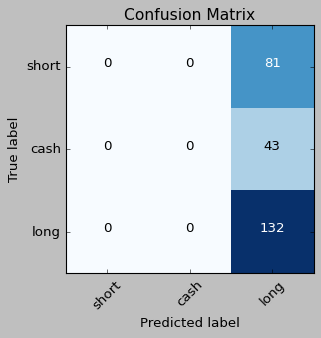

In [76]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

In [77]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

              precision    recall  f1-score   support

       short       0.00      0.00      0.00        81
        cash       0.00      0.00      0.00        43
        long       0.52      1.00      0.68       132

    accuracy                           0.52       256
   macro avg       0.17      0.33      0.23       256
weighted avg       0.27      0.52      0.35       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
hyper_parameters # window 20

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,8,24,40,120,0.00009,256,42.49,0.680412,0.515625,0.0,0.0,0.541295,0.0,0.0


In [79]:
hyper_parameters

,kernel_size,filters,unit,epoch,lr,batch,time,long_fscore_test,long_prec,cash_prec,short_prec,long_prec_train,cash_prec_train,short_prec_train
0,8,24,40,120,0.00009,256,42.49,0.680412,0.515625,0.0,0.0,0.541295,0.0,0.0


In [ ]:
hyper_parameters

In [ ]:
hyper_parameters

# XGBoost Regressor

In [80]:
train_ratio = 0.8
window_size = 1
look_forward =20
batch_size = 16
seed_value= 0
lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t = [], [], [], [], [], []
time_table, smape_test, smape_train, mae_train, mae_test = [], [], [], [], []
mse_train, mse_test, r2_train, r2_test = [], [], [], []
lrs = [0.15]
cols = [0.7]
ns = [70]
depths = [3]
subs = [0.7]
gammas = [0]
counter = 0
for lr in lrs:
    for col in cols:
        for n in ns:
            for depth in depths:
                for gamma in gammas:
                    for sub in subs:
                        counter +=1
                        start_time = time.time()
                        total = len(lrs)*len(cols)*len(ns)*len(depths)*len(gammas)*len(subs)
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1))
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)

                        #just for dense ANN, remove this for lstm
                        y = y.ravel()
                        x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,]

                        model = XGBRegressor(learning_rate=lr, colsample_bytree = col, subsample = sub,
n_estimators=n, max_depth=depth, gamma=gamma, objective = 'reg:squarederror')
                        model.fit(x_train, y_train)
                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        accuracy_train_smape = round(smape(prediction_train, y_train), 2)
                        accuracy_test_smape = round(smape(prediction_test, y_test), 2)
                        accuracy_train_mse = round(mse(prediction_train, y_train), 5)
                        accuracy_test_mse = round(mse(prediction_test, y_test), 5)
                        accuracy_train_r2 = round(r2_score(prediction_train, y_train), 2)
                        accuracy_test_r2 = round(r2_score(prediction_test, y_test), 2)
                        accuracy_train_mae = round(mae(prediction_train, y_train), 4)
                        accuracy_test_mae = round(mae(prediction_test, y_test), 4)
                        smape_train.append(accuracy_train_smape)
                        smape_test.append(accuracy_test_smape)
                        mse_train.append(accuracy_train_mse)
                        mse_test.append(accuracy_test_mse)
                        r2_train.append(accuracy_train_r2)
                        r2_test.append(accuracy_test_r2)
                        mae_train.append(accuracy_train_mae)
                        mae_test.append(accuracy_test_mae)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        lrs_t.append(lr)
                        cols_t.append(col)
                        ns_t.append(n)
                        depths_t.append(depth)
                        subs_t.append(sub)
                        gamma_t.append(gamma)
                        print(round(end_time - start_time,2),counter, 'out of ', total,'lr = ', lr, 'col = ', col,
                        'n= ', n, 'depth =', depth, sub, accuracy_test_r2, accuracy_test_mae )
hyper_parameters = pd.DataFrame(list(zip(lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table, smape_train, smape_test,
mae_train, mae_test, mse_train, mse_test, r2_train, r2_test)), columns =['lrs','columns', 'n_estimator', 'depth',
'subsample', 'gamma', 'time', 'smape_train', 'smape_test','mae_train', 'mae_test', 'mse_train', 'mse_test', 'r2_train', 'r2_test'])
hyper_parameters = hyper_parameters.sort_values(by=['smape_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

2.12 1 out of  1 lr =  0.15 col =  0.7 n=  70 depth = 3 0.7 -2.53 0.0796


,lrs,columns,n_estimator,depth,subsample,gamma,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.15,0.7,70,3,0.7,0,2.12,94.25,143.29,0.039,0.0796,0.00254,0.0093,-0.2,-2.53


In [81]:
hyper_parameters = hyper_parameters.sort_values(by=['mae_test'], ascending=True)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

,lrs,columns,n_estimator,depth,subsample,gamma,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.15,0.7,70,3,0.7,0,2.12,94.25,143.29,0.039,0.0796,0.00254,0.0093,-0.2,-2.53


In [ ]:
hyper_parameters

In [82]:
hyper_parameters.head(20)

,lrs,columns,n_estimator,depth,subsample,gamma,time,smape_train,smape_test,mae_train,mae_test,mse_train,mse_test,r2_train,r2_test
0,0.15,0.7,70,3,0.7,0,2.12,94.25,143.29,0.039,0.0796,0.00254,0.0093,-0.2,-2.53


In [83]:
accuracy_train_smape

94.25

(0.0, 900.0, -0.1, 0.1)

<Figure size 640x480 with 0 Axes>

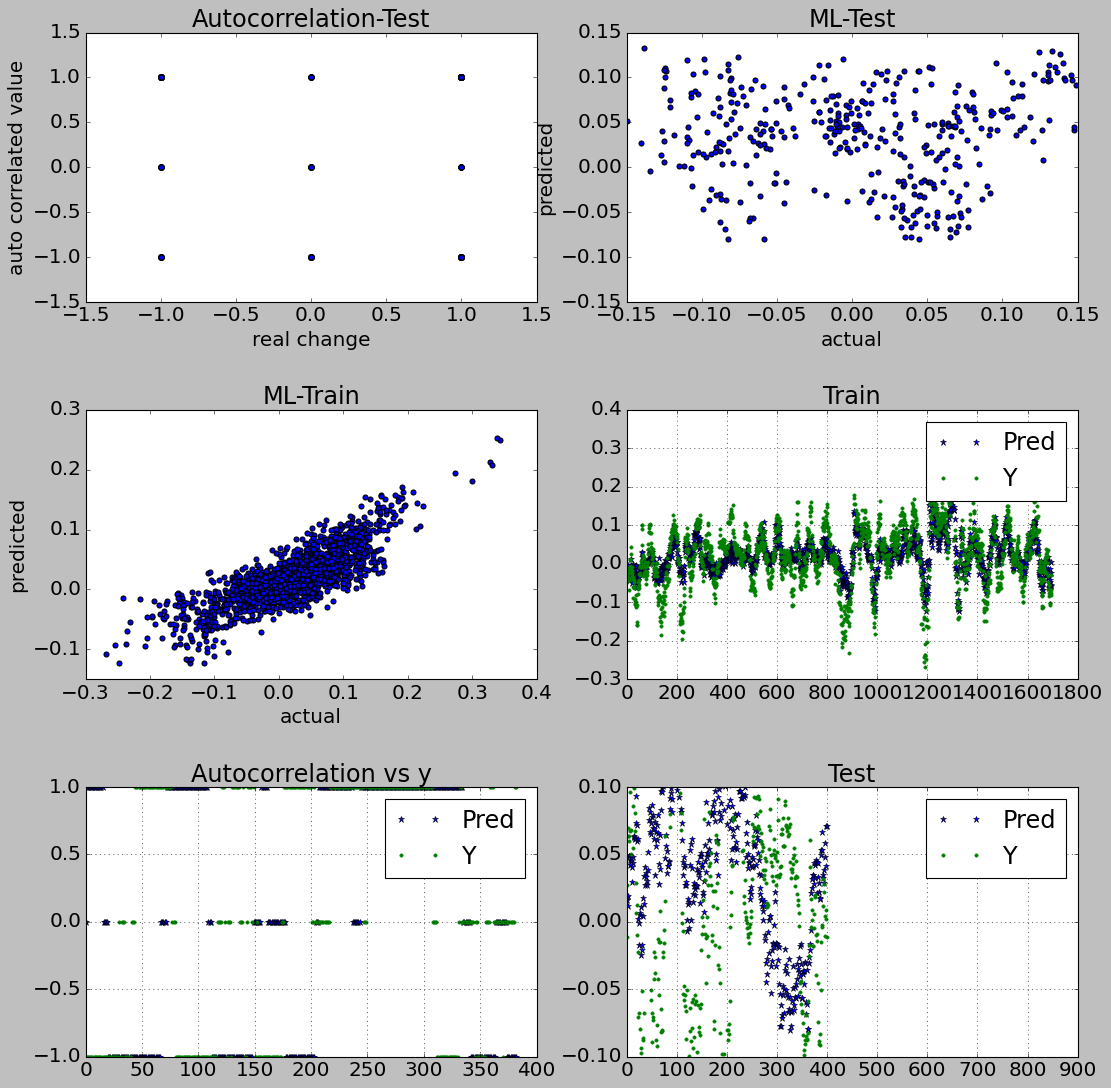

In [84]:
fig = plt.figure()
plt.rcParams.update({'font.size': 18})
plt.subplots_adjust(hspace = 0.4)
plt.figure(figsize=(16,16))
plt.subplot(3, 2, 1)
plt.scatter(y1,y2)
plt.ylabel('auto correlated value')
plt.xlabel('real change')
plt.title('Autocorrelation-Test')
plt.subplots_adjust(hspace = 0.4)

plt.subplot(3, 2, 2)
plt.scatter(y_test, prediction_test)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Test')
plt.axis([-0.15, 0.15, -0.15, 0.15])

plt.subplot(3, 2, 3)
plt.scatter(y_train, prediction_train)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.title('ML-Train')

plt.subplot(3, 2, 4)
plt.plot(prediction_train, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y_train, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Train')

plt.subplot(3, 2, 5)
plt.plot(y2, marker = '*',linestyle="None", label = 'Pred')
plt.plot(y1, marker = '.', label = 'Y', linestyle="None")
plt.grid()
plt.legend()
plt.title('Autocorrelation vs y')

plt.subplot(3, 2, 6)
plt.plot(prediction_test, marker = '*', label = 'Pred',linestyle="None")
plt.plot(y_test, marker = '.',linestyle="None" , label = 'Y')
plt.grid()
plt.legend()
plt.title('Test')
plt.axis([0, 900, -0.1, 0.1])

In [104]:
# save pipe.pkl to output data folder
!cp <output-file-name> /content/drive/MyDrive/1_Output

/bin/bash: line 1: output-file-name: No such file or directory


In [105]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# Specify the directory in your Google Drive where you want to save the PDF
pdf_directory = '/content/drive/My Drive/1_Output/'

# Ensure the directory exists
os.makedirs(pdf_directory, exist_ok=True)

# Create a single PDF file for all the plots
pdf_path = os.path.join(pdf_directory, 'all_plots.pdf')
pdf = PdfPages(pdf_path)

number_of_plots = 20  # Replace with the actual number of plots you have
for i in range(number_of_plots):
    plt.figure()
    # Your plotting code here, for example:
    plt.plot([1, 2, 3], [1, 4, 9])  # Replace with your own plotting code
    plt.title(f'Plot number {i}')
    pdf.savefig()  # saves the current figure into the pdf
    plt.close()  # close the figure

# Close the PDF file when all plots are saved
pdf.close()


In [106]:
!pip install nbconvert

# install texlive

In [117]:
!apt-get install texlive-xetex

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-ja

In [121]:
!pip install --upgrade nbconvert
!apt-get update
!apt-get install texlive-xetex


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.6/256.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [624 kB]
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,203 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,010 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,40

# PDF

In [124]:
import os
from nbconvert import PDFExporter

notebook_path = '/content/drive/MyDrive/2_SP/Stocks_Comparison_KNN,_Random_Forest,_LSTM,_CNN,_XGboost.ipynb'  # Replace with your .ipynb file path
pdf_output_path = 'output.pdf'  # Replace with your desired output PDF file path

# Create a PDF exporter with the custom template
pdf_exporter = PDFExporter(template_file='/content/drive/MyDrive/1_Output/no_code.tplx')  # Replace with the path to your custom template

# Export the notebook to PDF
pdf_exporter.from_filename(notebook_path)
pdf_exporter.writer.build()

# Move the generated PDF to the desired location
os.rename(pdf_exporter.writer.pdf_filename, pdf_output_path)


FileNotFoundError: ignored

In [125]:
import nbformat
from nbconvert import PDFExporter
import os

def export_notebook_to_pdf(notebook_path, pdf_output_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    # Create a PDF exporter
    pdf_exporter = PDFExporter()

    # Configure the exporter to exclude code cells
    pdf_exporter.exclude_input = True

    # Export the notebook to PDF
    pdf_data, resources = pdf_exporter.from_notebook_node(notebook_content)

    # Save the PDF to the specified output path
    with open(pdf_output_path, 'wb') as pdf_file:
        pdf_file.write(pdf_data)

# Specify the paths
notebook_path = '/content/drive/MyDrive/2_SP/Stocks_Comparison_KNN,_Random_Forest,_LSTM,_CNN,_XGboost.ipynb'  # Replace with your .ipynb file path
pdf_output_path = '/content/drive/MyDrive/1_Output/output.pdf'  # Replace with your desired output PDF file path

# Export the notebook to PDF without code cells
export_notebook_to_pdf(notebook_path, pdf_output_path)


TemplateAssertionError: ignored

In [135]:
import nbformat
from nbconvert import LatexExporter
import os

def export_notebook_to_pdf_without_code(notebook_path, pdf_output_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    # Create a Latex exporter with the custom template
    latex_exporter = LatexExporter(template_file='/content/drive/MyDrive/1_Output/no_code.tplx')  # Replace with the path to your custom template

    # Export the notebook to LaTeX
    latex_body, _ = latex_exporter.from_notebook_node(notebook_content)

    # Save the LaTeX content to a .tex file
    tex_output_path = 'output.tex'
    with open(tex_output_path, 'w', encoding='utf-8') as tex_file:
        tex_file.write(latex_body)

    # Use pdflatex to convert LaTeX to PDF
    os.system(f'pdflatex {tex_output_path}')

    # Rename the PDF file to the desired output path
    os.rename('/content/drive/MyDrive/1_Output/', pdf_output_path)

# Specify the paths here, and then call the function
notebook_path = '/content/drive/MyDrive/2_SP/Stocks_Comparison_KNN,_Random_Forest,_LSTM,_CNN,_XGboost.ipynb'  # Replace with your .ipynb file path
pdf_output_path = '/content/drive/MyDrive/1_Output/'  # Replace with your desired output PDF file path

# Export the notebook to PDF without code cells
export_notebook_to_pdf_without_code(notebook_path, pdf_output_path)


# XGboost Classifier

In [92]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [95]:
train_ratio = 0.8
window_size = 1
look_forward =20
batch_size = 16
seed_value= 0

def fix_rnd_Keras():
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table = [], [], [], [], [], [], []
long_prec ,cash_prec, short_prec, long_recal, cash_recal, short_recal, long_prec_tr, l_f_s_t =  [],[],[],[],[],[],[], []
cash_prec_tr, short_prec_tr, long_recal_tr, cash_recal_tr, short_recal_tr, long_fscores =  [], [], [], [], [], []
lrs = [2]
cols = [ 1]
ns = [ 150]
depths = [2]
subs = [0.6]
gammas = [ 13]
counter = 0
# Begin of the loop for hyperparameter tuning
for lr in lrs:
    for col in cols:
        for n in ns:
            for depth in depths:
                for gamma in gammas:
                    for sub in subs:
                        counter += 1
                        start_time = time.time()
                        total = len(lrs) * len(cols) * len(ns) * len(depths) * len(gammas) * len(subs)
                        fix_rnd_Keras()

                        scaler = MinMaxScaler(feature_range=(0.00001, 1))
                        MAs_scaled = scaler.fit_transform(MAs)
                        x, y_scaled = create_dataset_percentage_gap(MAs_scaled, window_size, look_forward,1)
                        MAs_array = MAs.values
                        x_scaled, y = create_dataset_percentage_gap(MAs_array, window_size, look_forward,1)
                        y = y_classifier(y, 0.02)
                        # Mapping -1 to 0, 0 to 1, and 1 to 2
                        class_mapping = {-1: 0, 1: 0, 1: 2}
                        y_train_mapped = np.vectorize(class_mapping.get)(y)
                        #just for dense ANN, remove this for lstm
                        y = y.ravel()
                        x = x.reshape(len(x), -1)
                        train_length = int(len(x)*train_ratio)

                        for i in range(train_length, train_length+batch_size):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length = i
                                break
                        x_train = x[:train_length,:]
                        y_train = y[:train_length,]

                        for i in range(len(x)-batch_size, len(x)):
                            remainder = i%batch_size
                            if remainder == 0:
                                train_length_test = i
                                break
                        x_test = x[train_length:train_length_test,:]
                        y_test = y[train_length:train_length_test,]

                        model = XGBClassifier(learning_rate=lr, colsample_bytree = col, subsample = sub,
n_estimators=n, max_depth=depth, gamma=gamma, objective = 'reg:squarederror')
                        model.fit(x_train, y_train)
                        prediction_train = model.predict(x_train)
                        prediction_test = model.predict(x_test)
                        rpt = classification_report(y_test_mapped, prediction_test, labels=[0, 1, 2], target_names=['short', 'cash', 'long'],
                                                    output_dict=True)
                        long_precision =  rpt['long']['precision']
                        long_fscore = rpt['long']['f1-score']
                        cash_precision =  rpt['cash']['precision']
                        short_precision =  rpt['short']['precision']
                        long_rec =  rpt['long']['recall']
                        cash_rec =  rpt['cash']['recall']
                        short_rec =  rpt['short']['recall']
                        rptt = classification_report(y_train, prediction_train, target_names = ['short','cash','long'],
                                                     output_dict=True )
                        long_precision_t =  rptt['long']['precision']
                        cash_precision_t =  rptt['cash']['precision']
                        short_precision_t =  rptt['short']['precision']
                        long_rec_t =  rptt['long']['recall']
                        cash_rec_t =  rptt['cash']['recall']
                        short_rec_t =  rptt['short']['recall']
                        long_fscore_t = rptt['long']['f1-score']
                        long_prec.append(long_precision)
                        cash_prec.append(cash_precision)
                        short_prec.append(short_precision)
                        long_recal.append(long_rec)
                        cash_recal.append(cash_rec)
                        short_recal.append(short_rec)
                        long_prec_tr.append(long_precision_t)
                        cash_prec_tr.append(cash_precision_t)
                        short_prec_tr.append(short_precision_t)
                        long_recal_tr.append(long_rec_t)
                        cash_recal_tr.append(cash_rec_t)
                        short_recal_tr.append(short_rec_t)
                        long_fscores.append(long_fscore)
                        end_time = time.time()
                        time_table.append(round(end_time - start_time,2))
                        lrs_t.append(lr)
                        cols_t.append(col)
                        ns_t.append(n)
                        depths_t.append(depth)
                        subs_t.append(sub)
                        gamma_t.append(gamma)
                        l_f_s_t.append(long_fscore_t)
                        print(round(end_time - start_time,2),counter, 'out of ', total,'lr = ', lr, 'col = ', col,
                        'n= ', n, 'depth =', depth, long_fscore, long_fscore_t )

hyper_parameters = pd.DataFrame(list(zip(lrs_t, cols_t, ns_t, depths_t, subs_t, gamma_t, time_table, long_fscores,
long_prec, cash_prec, short_prec, long_prec_tr, cash_prec_tr, short_prec_tr, l_f_s_t)), columns =['lrs','columns',
'n_estimator', 'depth','subsample', 'gamma', 'time', 'long_fscore_test', 'long_prec',
'cash_prec', 'short_prec', 'long_prec_train', 'cash_prec_train', 'short_prec_train', 'long_fscore_train'])
hyper_parameters = hyper_parameters.sort_values(by=['long_fscore_test'], ascending=False)
hyper_parameters = hyper_parameters.reset_index(drop=True)
hyper_parameters

TypeError: ignored

In [88]:
plt.style.use('classic')
plt.figure(figsize=(4,4))
plt.subplots_adjust(hspace = 0.1)
pretty_print_conf_matrix(y_test,prediction_test, classes= ['short', 'cash', 'long'],
normalize=False, title='Confusion Matrix')

ValueError: ignored

<Figure size 320x320 with 0 Axes>

In [89]:
rpt = classification_report(y_test, prediction_test, target_names = ['short', 'cash', 'long'])
print(rpt)

ValueError: ignored

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
import matplotlib.pyplot as plt
import os

# Specify the directory in your Google Drive where you want to save the PDFs
pdf_directory = '/content/drive/My Drive/2_SP/'

# Ensure the directory exists
os.makedirs(pdf_directory, exist_ok=True)

# Let's assume you have a number of plots to create; for each plot:
number_of_plots = 20  # Replace with the actual number of plots you have
for i in range(number_of_plots):
    # Create a unique file name for each plot
    pdf_path = os.path.join(pdf_directory, f'plot_number_{i}.pdf')
    with PdfPages(pdf_path) as pdf:
        plt.figure()
        # Your plotting code here, for example:
        plt.plot([1, 2, 3], [1, 4, 9])  # Replace with your own plotting code
        plt.title(f'Plot number {i}')
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()  # close the figure
